In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-07-08 15:17:26.290835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1892] Ignoring visible gpu device (device: 0, name: Quadro K2000, pci bus id: 0000:05:00.0, compute capability: 3.0) with Cuda compute capability 3.0. The minimum required Cuda capability is 3.5.


# Load data

In [2]:
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']


In [3]:
data_path = os.path.abspath("turing_model_2.npy")
with open(data_path, 'rb') as f:
    data2 = np.load(f)
    
data_path = os.path.abspath("turing_t_model_2.npy")
with open(data_path, 'rb') as f:
    t_star2 = np.load(f) 
    
T2 = t_star2.shape[0]    
    
L2 = 50
x_size2 = data2.shape[1]
y_size2 = data2.shape[2]
N2 = x_size2*y_size2

model_params2 = {'training_data_size': T2*N2,#T*32,
                'pde_data_size': (T2*N2)//(32),
                'boundary_data_size':((x_size2 + y_size2)*T2)//(8)}

dataset2 = create_dataset(data2, t_star2, N2, T2, L2, **model_params2)
lb2 = dataset['lb']
ub2 = dataset['ub']
obs_X2 = dataset2['obs_input']
obs_Y2 = dataset2['obs_output']
pde_X2 = dataset2['pde']

# Test 

In [4]:
layers = [3, 64, 64, 64, 64, 2]

pinn = tu.NN(layers, lb, ub, dtype=tf.float64)

In [5]:
class dumy_loss(Loss):
    def __init__(self,                                
                 print_precision=".5f"):
        """DUMY PDE loss           
        """

        super().__init__(name="Loss_Dummy", print_precision=print_precision) 
        self.c = tf.constant(0.0, dtype= tf.float64)
        
    @tf.function
    def loss(self, pinn, x):
        outputs = pinn(x)         

        return outputs, self.c , self.c 


In [6]:
dummy_loss = dumy_loss()

In [7]:
model = tu.TINN(pinn, 
                dummy_loss,  
                alpha = 0.5, 
                print_precision=".8f")

In [ ]:
#tf.executing_eagerly()
results = model.train(epochs = 100,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True,
                      regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.14878809
total loss: 304.71794506, total regularisd loss: 304.71794506
obs u loss: 262.30006045, obs v loss: 42.41788461
pde u loss: 0.00000000, pde v loss: 0.00000000
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000

Time taken: 6.57s

Start of epoch 1
Training observations acc over epoch: 0.13234077
total loss: 271.03398330, total regularisd loss: 271.03398330
obs u loss: 248.05665434, obs v loss: 22.97732895
pde u loss: 0.00000000, pde v loss: 0.00000000
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000

Time taken: 4.19s

Start of epoch 2
Training observations acc over epoch: 0.13225973
total loss: 270.86783878, total regularisd loss: 270.86783878
obs u loss: 247.94646128, obs v loss: 22.92137750
pde u loss: 0.00000000, pde v loss: 0.00000000
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lam

In [50]:

pde_loss = ASDM(dtype=tf.float64)

    
non_zero_loss = Non_zero_params(pde_loss.name, [pde_loss.D_a, pde_loss.D_s])
    

In [51]:
model = tu.TINN(pinn, 
                pde_loss, 
                extra_loss = [non_zero_loss], 
                optimizer = keras.optimizers.SGD(learning_rate=1e-4),
                alpha = 0.5, 
                print_precision=".8f")

In [52]:
#tf.executing_eagerly()
results = model.train(epochs = 100,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True#,                      
                #step_callback=step_callback#,
               #epoch_callback=epoch_callback
                     )


Start of epoch 0
Training observations acc over epoch: 6.99788857
total loss: 25816.98942874, total regularisd loss: 25816.98942874
obs u loss: 575.84194296, obs v loss: 13755.81721540
pde u loss: 454.29142304, pde v loss: 11031.03882792
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
D_a: 9.64659 D_s: 12.28526 sigma_a: 10.02789 sigma_s: 8.42597 
mu_a: 9.79712 rho_a: 10.27951 rho_s: 11.78632 kappa_a: 8.10794 

extra loss Non-zero params for Loss_ASDM: 0.00001941
Time taken: 54.63s

Start of epoch 1
Training observations acc over epoch: 4.17455959
total loss: 12006.58226021, total regularisd loss: 12006.58226021
obs u loss: 582.11480331, obs v loss: 7967.37594602
pde u loss: 0.88614077, pde v loss: 3456.20535133
lambda obs u: 0.55975426, lambda obs v: 2.14961529
lambda pde u: 0.50000047, lambda pde v: 0.79062998
D_a: 9.50315 D_s: 13.02855 sigma_a: 10.07681 sigma_s: 7.60322 
mu_a: 9.69623 rho_a: 10.41512 rho_s: 12.60009 kappa_a: 7.15

KeyboardInterrupt: 

In [7]:
#tf.executing_eagerly()
results = model.train(epochs = 100,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True#,                      
                #step_callback=step_callback#,
               #epoch_callback=epoch_callback
                     )


Start of epoch 0
Training observations acc over epoch: 8.21186924
total loss: 37066.87831569, total regularisd loss: 37066.87831569
obs u loss: 584.85240067, obs v loss: 16233.06057872
pde u loss: 1047.97146828, pde v loss: 19200.99384814
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
D_a: 9.78492 D_s: 11.39616 sigma_a: 10.02288 sigma_s: 9.21644 
mu_a: 9.85127 rho_a: 10.61554 rho_s: 11.05805 kappa_a: 8.90673 

extra loss Non-zero params for Loss_ASDM: 0.00001988
Time taken: 49.27s

Start of epoch 1
Training observations acc over epoch: 6.33050299
total loss: 20228.35714711, total regularisd loss: 20228.35714711
obs u loss: 651.69460270, obs v loss: 12313.17411283
pde u loss: 3.62759351, pde v loss: 7259.86081882
lambda obs u: 0.53014811, lambda obs v: 1.98693160
lambda pde u: 0.50000134, lambda pde v: 0.98291895
D_a: 9.42486 D_s: 12.36239 sigma_a: 10.06594 sigma_s: 8.44125 
mu_a: 9.69396 rho_a: 11.05628 rho_s: 11.87611 kappa_a: 7.

Training observations acc over epoch: 0.12381107
total loss: 662.13163758, total regularisd loss: 719.92012352
obs u loss: 182.31012917, obs v loss: 71.25491036
pde u loss: 295.79620447, pde v loss: 112.77036929
lambda obs u: 3.37259100, lambda obs v: 0.21594693
lambda pde u: 0.25587900, lambda pde v: 0.15558307
D_a: 5.61183 D_s: 13.50412 sigma_a: 6.98766 sigma_s: 4.28159 
mu_a: 10.15699 rho_a: 11.04188 rho_s: 14.60321 kappa_a: 3.14340 

extra loss Non-zero params for Loss_ASDM: 0.00002429
Time taken: 25.38s

Start of epoch 17
Training observations acc over epoch: 0.12278049
total loss: 563.05872719, total regularisd loss: 706.63263647
obs u loss: 184.61927278, obs v loss: 66.83502600
pde u loss: 210.11942377, pde v loss: 101.48497739
lambda obs u: 3.40454831, lambda obs v: 0.22029342
lambda pde u: 0.21998572, lambda pde v: 0.15517254
D_a: 4.93051 D_s: 12.88287 sigma_a: 6.68568 sigma_s: 4.25997 
mu_a: 10.00400 rho_a: 11.24640 rho_s: 14.18195 kappa_a: 3.05209 

extra loss Non-zero param

Training observations acc over epoch: 0.03698767
total loss: 179.93401159, total regularisd loss: 170.33820040
obs u loss: 36.36400756, obs v loss: 39.38668434
pde u loss: 68.37310852, pde v loss: 35.80966136
lambda obs u: 1.79692058, lambda obs v: 0.52691529
lambda pde u: 0.82874027, lambda pde v: 0.84742386
D_a: 0.53934 D_s: 15.33737 sigma_a: 0.00000 sigma_s: 0.79660 
mu_a: 6.15619 rho_a: 13.14399 rho_s: 1.75055 kappa_a: 1.27076 

extra loss Non-zero params for Loss_ASDM: 0.00054980
Time taken: 25.83s

Start of epoch 33
Training observations acc over epoch: 0.03150040
total loss: 139.02006985, total regularisd loss: 135.15212261
obs u loss: 30.72925241, obs v loss: 33.78353765
pde u loss: 53.85674915, pde v loss: 20.65036885
lambda obs u: 1.55969705, lambda obs v: 0.68209611
lambda pde u: 0.88702337, lambda pde v: 0.87118347
D_a: 0.73398 D_s: 15.21227 sigma_a: 0.00000 sigma_s: 0.41578 
mu_a: 6.22791 rho_a: 12.81555 rho_s: 0.89331 kappa_a: 1.24742 

extra loss Non-zero params for Loss

Training observations acc over epoch: 0.00729280
total loss: 31.12842458, total regularisd loss: 32.35943218
obs u loss: 8.20750432, obs v loss: 6.72814879
pde u loss: 16.10652765, pde v loss: 0.08546992
lambda obs u: 1.71743362, lambda obs v: 1.34292350
lambda pde u: 0.68744284, lambda pde v: 0.25220005
D_a: 0.95386 D_s: 0.06471 sigma_a: 0.38555 sigma_s: 0.00434 
mu_a: 7.23999 rho_a: 9.67558 rho_s: 0.00615 kappa_a: 0.63661 

extra loss Non-zero params for Loss_ASDM: 0.00077390
Time taken: 25.99s

Start of epoch 49
Training observations acc over epoch: 0.00666167
total loss: 28.05559346, total regularisd loss: 30.92035173
obs u loss: 7.19044370, obs v loss: 6.45265467
pde u loss: 14.40404145, pde v loss: 0.00613581
lambda obs u: 1.74698585, lambda obs v: 1.46219113
lambda pde u: 0.66435874, lambda pde v: 0.12646428
D_a: 0.87701 D_s: 0.04055 sigma_a: 0.46988 sigma_s: 0.00280 
mu_a: 7.30594 rho_a: 9.52410 rho_s: 0.00388 kappa_a: 0.61482 

extra loss Non-zero params for Loss_ASDM: 0.00231

Training observations acc over epoch: 0.00219519
total loss: 10.30727689, total regularisd loss: 10.76133516
obs u loss: 2.54451046, obs v loss: 1.95124110
pde u loss: 5.77459826, pde v loss: 0.03510109
lambda obs u: 1.45662554, lambda obs v: 1.94398625
lambda pde u: 0.57611097, lambda pde v: 0.02327723
D_a: 0.42745 D_s: 0.06555 sigma_a: 1.30830 sigma_s: 0.00621 
mu_a: 8.18835 rho_a: 7.73418 rho_s: 0.00682 kappa_a: 0.35454 

extra loss Non-zero params for Loss_ASDM: 0.00182598
Time taken: 25.67s

Start of epoch 65
Training observations acc over epoch: 0.00213743
total loss: 10.02806401, total regularisd loss: 10.52549918
obs u loss: 2.50591019, obs v loss: 1.87154504
pde u loss: 5.61424699, pde v loss: 0.03452619
lambda obs u: 1.53660014, lambda obs v: 1.88664304
lambda pde u: 0.55381628, lambda pde v: 0.02294054
D_a: 0.42319 D_s: 0.06295 sigma_a: 1.32953 sigma_s: 0.00732 
mu_a: 8.20337 rho_a: 7.67623 rho_s: 0.00721 kappa_a: 0.34849 

extra loss Non-zero params for Loss_ASDM: 0.0018356

Training observations acc over epoch: 0.00174840
total loss: 8.35289023, total regularisd loss: 8.69089233
obs u loss: 2.16994697, obs v loss: 1.41077911
pde u loss: 4.73881696, pde v loss: 0.03142877
lambda obs u: 1.49824621, lambda obs v: 1.87907717
lambda pde u: 0.59528958, lambda pde v: 0.02738703
D_a: 0.40973 D_s: 0.06272 sigma_a: 1.40998 sigma_s: 0.00645 
mu_a: 8.13777 rho_a: 7.22951 rho_s: 0.00664 kappa_a: 0.30980 

extra loss Non-zero params for Loss_ASDM: 0.00191843
Time taken: 25.82s

Start of epoch 81
Training observations acc over epoch: 0.00171236
total loss: 8.15968120, total regularisd loss: 8.54023698
obs u loss: 2.10784307, obs v loss: 1.39906394
pde u loss: 4.62040365, pde v loss: 0.03046300
lambda obs u: 1.48477906, lambda obs v: 1.89547219
lambda pde u: 0.59143498, lambda pde v: 0.02831377
D_a: 0.40935 D_s: 0.05804 sigma_a: 1.40965 sigma_s: 0.00647 
mu_a: 8.12529 rho_a: 7.21128 rho_s: 0.00691 kappa_a: 0.30910 

extra loss Non-zero params for Loss_ASDM: 0.00190753
Ti

Training observations acc over epoch: 0.00153436
total loss: 7.28228708, total regularisd loss: 7.61268960
obs u loss: 1.86100304, obs v loss: 1.28136617
pde u loss: 4.10871174, pde v loss: 0.02919139
lambda obs u: 1.44024745, lambda obs v: 1.92193240
lambda pde u: 0.60933332, lambda pde v: 0.02848682
D_a: 0.41059 D_s: 0.05560 sigma_a: 1.38266 sigma_s: 0.00638 
mu_a: 7.92829 rho_a: 6.96589 rho_s: 0.00643 kappa_a: 0.30082 

extra loss Non-zero params for Loss_ASDM: 0.00201473
Time taken: 25.84s

Start of epoch 97
Training observations acc over epoch: 0.00153503
total loss: 7.22979218, total regularisd loss: 7.61683524
obs u loss: 1.86374286, obs v loss: 1.28000716
pde u loss: 4.05295655, pde v loss: 0.03107523
lambda obs u: 1.43596871, lambda obs v: 1.93852645
lambda pde u: 0.59632608, lambda pde v: 0.02917877
D_a: 0.40854 D_s: 0.05680 sigma_a: 1.38283 sigma_s: 0.00667 
mu_a: 7.91448 rho_a: 6.95012 rho_s: 0.00691 kappa_a: 0.30048 

extra loss Non-zero params for Loss_ASDM: 0.00201039
Ti

In [15]:
results2 = model.train(epochs = 200,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.00151574
total loss: 7.21005834, total regularisd loss: 7.52248776
obs u loss: 1.84291733, obs v loss: 1.26132367
pde u loss: 4.07436817, pde v loss: 0.02946748
lambda obs u: 1.46283991, lambda obs v: 1.91714718
lambda pde u: 0.59042234, lambda pde v: 0.02959057
D_a: 0.41253 D_s: 0.06023 sigma_a: 1.37231 sigma_s: 0.00646 
mu_a: 7.87220 rho_a: 6.90627 rho_s: 0.00654 kappa_a: 0.29903 

extra loss Non-zero params for Loss_ASDM: 0.00198168
Time taken: 25.71s

Start of epoch 1
Training observations acc over epoch: 0.00148622
total loss: 7.13621759, total regularisd loss: 7.42152286
obs u loss: 1.79238171, obs v loss: 1.25139663
pde u loss: 4.06077572, pde v loss: 0.02967034
lambda obs u: 1.43616209, lambda obs v: 1.93419412
lambda pde u: 0.59967840, lambda pde v: 0.02996538
D_a: 0.41143 D_s: 0.05835 sigma_a: 1.37013 sigma_s: 0.00665 
mu_a: 7.85708 rho_a: 6.89163 rho_s: 0.00691 kappa_a: 0.29933 

extra loss Non-zero params for Loss_AS

Training observations acc over epoch: 0.00140631
total loss: 6.66270648, total regularisd loss: 6.96364475
obs u loss: 1.70029585, obs v loss: 1.17983419
pde u loss: 3.75163616, pde v loss: 0.02894887
lambda obs u: 1.44241367, lambda obs v: 1.93468884
lambda pde u: 0.59153722, lambda pde v: 0.03136028
D_a: 0.41066 D_s: 0.06035 sigma_a: 1.33192 sigma_s: 0.00575 
mu_a: 7.64110 rho_a: 6.67168 rho_s: 0.00631 kappa_a: 0.29508 

extra loss Non-zero params for Loss_ASDM: 0.00199140
Time taken: 27.36s

Start of epoch 17
Training observations acc over epoch: 0.00137123
total loss: 6.51895778, total regularisd loss: 6.80877910
obs u loss: 1.63295962, obs v loss: 1.17531748
pde u loss: 3.67943509, pde v loss: 0.02918130
lambda obs u: 1.39801138, lambda obs v: 1.96308745
lambda pde u: 0.60823790, lambda pde v: 0.03066327
D_a: 0.41086 D_s: 0.05771 sigma_a: 1.32907 sigma_s: 0.00627 
mu_a: 7.62630 rho_a: 6.65829 rho_s: 0.00641 kappa_a: 0.29513 

extra loss Non-zero params for Loss_ASDM: 0.00206429
Ti

Training observations acc over epoch: 0.00131910
total loss: 6.18048419, total regularisd loss: 6.50860851
obs u loss: 1.57844946, obs v loss: 1.12306756
pde u loss: 3.44980853, pde v loss: 0.02713075
lambda obs u: 1.39274291, lambda obs v: 1.97221618
lambda pde u: 0.60060680, lambda pde v: 0.03443411
D_a: 0.41233 D_s: 0.05836 sigma_a: 1.28543 sigma_s: 0.00568 
mu_a: 7.40039 rho_a: 6.45039 rho_s: 0.00664 kappa_a: 0.29267 

extra loss Non-zero params for Loss_ASDM: 0.00202789
Time taken: 26.59s

Start of epoch 33
Training observations acc over epoch: 0.00129937
total loss: 6.11077759, total regularisd loss: 6.41051995
obs u loss: 1.54546677, obs v loss: 1.11564969
pde u loss: 3.42123811, pde v loss: 0.02637023
lambda obs u: 1.38196510, lambda obs v: 1.97185303
lambda pde u: 0.61251860, lambda pde v: 0.03366326
D_a: 0.41245 D_s: 0.05724 sigma_a: 1.28063 sigma_s: 0.00599 
mu_a: 7.38639 rho_a: 6.43584 rho_s: 0.00621 kappa_a: 0.29225 

extra loss Non-zero params for Loss_ASDM: 0.00205278
Ti

Training observations acc over epoch: 0.00122152
total loss: 5.72114708, total regularisd loss: 6.00931960
obs u loss: 1.44459199, obs v loss: 1.05708848
pde u loss: 3.19112589, pde v loss: 0.02623924
lambda obs u: 1.34019586, lambda obs v: 1.99646675
lambda pde u: 0.62951062, lambda pde v: 0.03382678
D_a: 0.41110 D_s: 0.05600 sigma_a: 1.23880 sigma_s: 0.00621 
mu_a: 7.16313 rho_a: 6.22085 rho_s: 0.00592 kappa_a: 0.28909 

extra loss Non-zero params for Loss_ASDM: 0.00210148
Time taken: 26.19s

Start of epoch 49
Training observations acc over epoch: 0.00123172
total loss: 5.67707128, total regularisd loss: 6.04451897
obs u loss: 1.46618666, obs v loss: 1.05636758
pde u loss: 3.12555021, pde v loss: 0.02690505
lambda obs u: 1.37914082, lambda obs v: 1.97540850
lambda pde u: 0.60990076, lambda pde v: 0.03554992
D_a: 0.40795 D_s: 0.05730 sigma_a: 1.24035 sigma_s: 0.00619 
mu_a: 7.14774 rho_a: 6.20574 rho_s: 0.00610 kappa_a: 0.28896 

extra loss Non-zero params for Loss_ASDM: 0.00206178
Ti

Training observations acc over epoch: 0.00115784
total loss: 5.35299925, total regularisd loss: 5.67681179
obs u loss: 1.36529646, obs v loss: 1.00595613
pde u loss: 2.95433764, pde v loss: 0.02528808
lambda obs u: 1.35667872, lambda obs v: 1.98991906
lambda pde u: 0.61704780, lambda pde v: 0.03635442
D_a: 0.40873 D_s: 0.05429 sigma_a: 1.19389 sigma_s: 0.00601 
mu_a: 6.92191 rho_a: 5.99970 rho_s: 0.00603 kappa_a: 0.28672 

extra loss Non-zero params for Loss_ASDM: 0.00212093
Time taken: 26.86s

Start of epoch 65
Training observations acc over epoch: 0.00115348
total loss: 5.33736970, total regularisd loss: 5.66022091
obs u loss: 1.36172769, obs v loss: 1.00060911
pde u loss: 2.94730348, pde v loss: 0.02562534
lambda obs u: 1.35728303, lambda obs v: 1.98553864
lambda pde u: 0.62014553, lambda pde v: 0.03703280
D_a: 0.40620 D_s: 0.05369 sigma_a: 1.19043 sigma_s: 0.00594 
mu_a: 6.90715 rho_a: 5.98531 rho_s: 0.00601 kappa_a: 0.28680 

extra loss Non-zero params for Loss_ASDM: 0.00210408
Ti

Training observations acc over epoch: 0.00110958
total loss: 5.02673734, total regularisd loss: 5.41458421
obs u loss: 1.30572227, obs v loss: 0.96670272
pde u loss: 2.72674523, pde v loss: 0.02544212
lambda obs u: 1.36155563, lambda obs v: 1.97424340
lambda pde u: 0.62581637, lambda pde v: 0.03838461
D_a: 0.40305 D_s: 0.05404 sigma_a: 1.14637 sigma_s: 0.00599 
mu_a: 6.67528 rho_a: 5.77781 rho_s: 0.00627 kappa_a: 0.28513 

extra loss Non-zero params for Loss_ASDM: 0.00212501
Time taken: 26.76s

Start of epoch 81
Training observations acc over epoch: 0.00109845
total loss: 4.98981476, total regularisd loss: 5.35397728
obs u loss: 1.28677435, obs v loss: 0.96286261
pde u loss: 2.71314483, pde v loss: 0.02488120
lambda obs u: 1.34073835, lambda obs v: 1.98848114
lambda pde u: 0.63317257, lambda pde v: 0.03760794
D_a: 0.40492 D_s: 0.05348 sigma_a: 1.14134 sigma_s: 0.00589 
mu_a: 6.65944 rho_a: 5.76397 rho_s: 0.00589 kappa_a: 0.28457 

extra loss Non-zero params for Loss_ASDM: 0.00215178
Ti

Training observations acc over epoch: 0.00105373
total loss: 4.73904190, total regularisd loss: 5.12485134
obs u loss: 1.23250375, obs v loss: 0.92552615
pde u loss: 2.55433072, pde v loss: 0.02451141
lambda obs u: 1.33040462, lambda obs v: 1.99395192
lambda pde u: 0.63655522, lambda pde v: 0.03908824
D_a: 0.40002 D_s: 0.05340 sigma_a: 1.09593 sigma_s: 0.00598 
mu_a: 6.42267 rho_a: 5.55339 rho_s: 0.00596 kappa_a: 0.28302 

extra loss Non-zero params for Loss_ASDM: 0.00216988
Time taken: 26.75s

Start of epoch 97
Training observations acc over epoch: 0.00104254
total loss: 4.70491353, total regularisd loss: 5.07267321
obs u loss: 1.21550801, obs v loss: 0.91960454
pde u loss: 2.54303396, pde v loss: 0.02460170
lambda obs u: 1.36267972, lambda obs v: 1.96768353
lambda pde u: 0.63044696, lambda pde v: 0.03918978
D_a: 0.40213 D_s: 0.05267 sigma_a: 1.09322 sigma_s: 0.00604 
mu_a: 6.40762 rho_a: 5.53916 rho_s: 0.00570 kappa_a: 0.28286 

extra loss Non-zero params for Loss_ASDM: 0.00216530
Ti

Training observations acc over epoch: 0.00100007
total loss: 4.43678313, total regularisd loss: 4.85754933
obs u loss: 1.15994266, obs v loss: 0.88820895
pde u loss: 2.36260775, pde v loss: 0.02382750
lambda obs u: 1.33532510, lambda obs v: 1.98264559
lambda pde u: 0.64143660, lambda pde v: 0.04059270
D_a: 0.39553 D_s: 0.05244 sigma_a: 1.04550 sigma_s: 0.00607 
mu_a: 6.16595 rho_a: 5.32801 rho_s: 0.00584 kappa_a: 0.28204 

extra loss Non-zero params for Loss_ASDM: 0.00219627
Time taken: 26.31s

Start of epoch 113
Training observations acc over epoch: 0.00099352
total loss: 4.44208655, total regularisd loss: 4.81793506
obs u loss: 1.15366319, obs v loss: 0.88107298
pde u loss: 2.38122324, pde v loss: 0.02393843
lambda obs u: 1.33404241, lambda obs v: 1.96919383
lambda pde u: 0.65615373, lambda pde v: 0.04061003
D_a: 0.39915 D_s: 0.05334 sigma_a: 1.04174 sigma_s: 0.00586 
mu_a: 6.14981 rho_a: 5.31414 rho_s: 0.00557 kappa_a: 0.28123 

extra loss Non-zero params for Loss_ASDM: 0.00218871
T

Training observations acc over epoch: 0.00095404
total loss: 4.20866490, total regularisd loss: 4.60382918
obs u loss: 1.11079277, obs v loss: 0.84308618
pde u loss: 2.22951436, pde v loss: 0.02305163
lambda obs u: 1.28683724, lambda obs v: 1.99958922
lambda pde u: 0.67224054, lambda pde v: 0.04133301
D_a: 0.39099 D_s: 0.05293 sigma_a: 0.99562 sigma_s: 0.00601 
mu_a: 5.90597 rho_a: 5.09744 rho_s: 0.00568 kappa_a: 0.27968 

extra loss Non-zero params for Loss_ASDM: 0.00221995
Time taken: 26.79s

Start of epoch 129
Training observations acc over epoch: 0.00094827
total loss: 4.17658209, total regularisd loss: 4.58573305
obs u loss: 1.10216654, obs v loss: 0.83988529
pde u loss: 2.20877303, pde v loss: 0.02355925
lambda obs u: 1.34762182, lambda obs v: 1.96418844
lambda pde u: 0.64631414, lambda pde v: 0.04187561
D_a: 0.39155 D_s: 0.05355 sigma_a: 0.99533 sigma_s: 0.00567 
mu_a: 5.89015 rho_a: 5.08217 rho_s: 0.00567 kappa_a: 0.27923 

extra loss Non-zero params for Loss_ASDM: 0.00219798
T

Training observations acc over epoch: 0.00090321
total loss: 3.96916327, total regularisd loss: 4.36731588
obs u loss: 1.04467615, obs v loss: 0.80510467
pde u loss: 2.09427662, pde v loss: 0.02289189
lambda obs u: 1.32078381, lambda obs v: 1.95812674
lambda pde u: 0.67788734, lambda pde v: 0.04320212
D_a: 0.38442 D_s: 0.05324 sigma_a: 0.94382 sigma_s: 0.00588 
mu_a: 5.63702 rho_a: 4.86251 rho_s: 0.00567 kappa_a: 0.27775 

extra loss Non-zero params for Loss_ASDM: 0.00221393
Time taken: 26.10s

Start of epoch 145
Training observations acc over epoch: 0.00089956
total loss: 3.92766360, total regularisd loss: 4.34596218
obs u loss: 1.03775690, obs v loss: 0.80454569
pde u loss: 2.06037614, pde v loss: 0.02276397
lambda obs u: 1.32203347, lambda obs v: 1.95402584
lambda pde u: 0.68043991, lambda pde v: 0.04350078
D_a: 0.38366 D_s: 0.05317 sigma_a: 0.93979 sigma_s: 0.00581 
mu_a: 5.62037 rho_a: 4.84751 rho_s: 0.00581 kappa_a: 0.27783 

extra loss Non-zero params for Loss_ASDM: 0.00222090
T

Training observations acc over epoch: 0.00086152
total loss: 3.71651932, total regularisd loss: 4.14904196
obs u loss: 0.99067253, obs v loss: 0.77371613
pde u loss: 1.92791317, pde v loss: 0.02197640
lambda obs u: 1.30975861, lambda obs v: 1.95215660
lambda pde u: 0.69316716, lambda pde v: 0.04491763
D_a: 0.37249 D_s: 0.05389 sigma_a: 0.89132 sigma_s: 0.00554 
mu_a: 5.36198 rho_a: 4.62273 rho_s: 0.00520 kappa_a: 0.27686 

extra loss Non-zero params for Loss_ASDM: 0.00224109
Time taken: 27.12s

Start of epoch 161
Training observations acc over epoch: 0.00086290
total loss: 3.71386728, total regularisd loss: 4.14529966
obs u loss: 0.99679179, obs v loss: 0.77042288
pde u loss: 1.92237565, pde v loss: 0.02203759
lambda obs u: 1.30258643, lambda obs v: 1.94911229
lambda pde u: 0.70425476, lambda pde v: 0.04404652
D_a: 0.37297 D_s: 0.05267 sigma_a: 0.88934 sigma_s: 0.00596 
mu_a: 5.34418 rho_a: 4.60714 rho_s: 0.00577 kappa_a: 0.27653 

extra loss Non-zero params for Loss_ASDM: 0.00223938
T

Training observations acc over epoch: 0.00081858
total loss: 3.50586226, total regularisd loss: 3.93541790
obs u loss: 0.94112657, obs v loss: 0.73533051
pde u loss: 1.80565407, pde v loss: 0.02150907
lambda obs u: 1.30799792, lambda obs v: 1.93606200
lambda pde u: 0.70856147, lambda pde v: 0.04737861
D_a: 0.36013 D_s: 0.05100 sigma_a: 0.84013 sigma_s: 0.00594 
mu_a: 5.08183 rho_a: 4.37832 rho_s: 0.00571 kappa_a: 0.27519 

extra loss Non-zero params for Loss_ASDM: 0.00224204
Time taken: 26.99s

Start of epoch 177
Training observations acc over epoch: 0.00081206
total loss: 3.46621176, total regularisd loss: 3.89880941
obs u loss: 0.93210822, obs v loss: 0.73099112
pde u loss: 1.77981623, pde v loss: 0.02103221
lambda obs u: 1.30589123, lambda obs v: 1.93106356
lambda pde u: 0.71673139, lambda pde v: 0.04631382
D_a: 0.36094 D_s: 0.05147 sigma_a: 0.83760 sigma_s: 0.00532 
mu_a: 5.06394 rho_a: 4.36271 rho_s: 0.00554 kappa_a: 0.27500 

extra loss Non-zero params for Loss_ASDM: 0.00226398
T

Training observations acc over epoch: 0.00078406
total loss: 3.27986712, total regularisd loss: 3.73622005
obs u loss: 0.90485575, obs v loss: 0.70090799
pde u loss: 1.65110163, pde v loss: 0.02073928
lambda obs u: 1.28621551, lambda obs v: 1.92635099
lambda pde u: 0.73972987, lambda pde v: 0.04770363
D_a: 0.34805 D_s: 0.05238 sigma_a: 0.78838 sigma_s: 0.00531 
mu_a: 4.79038 rho_a: 4.12395 rho_s: 0.00500 kappa_a: 0.27402 

extra loss Non-zero params for Loss_ASDM: 0.00226247
Time taken: 26.88s

Start of epoch 193
Training observations acc over epoch: 0.00077732
total loss: 3.25566327, total regularisd loss: 3.71101231
obs u loss: 0.89447191, obs v loss: 0.69747289
pde u loss: 1.64073764, pde v loss: 0.02072084
lambda obs u: 1.31387076, lambda obs v: 1.90318986
lambda pde u: 0.73424328, lambda pde v: 0.04869610
D_a: 0.34584 D_s: 0.05317 sigma_a: 0.78569 sigma_s: 0.00559 
mu_a: 4.77159 rho_a: 4.10683 rho_s: 0.00562 kappa_a: 0.27383 

extra loss Non-zero params for Loss_ASDM: 0.00225998
T

In [19]:
results3 = model.train(epochs = 200,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.00076498
total loss: 3.18213220, total regularisd loss: 3.65161553
obs u loss: 0.88041265, obs v loss: 0.68626886
pde u loss: 1.59254165, pde v loss: 0.02065108
lambda obs u: 1.31967172, lambda obs v: 1.88245451
lambda pde u: 0.75015084, lambda pde v: 0.04772292
D_a: 0.33885 D_s: 0.05295 sigma_a: 0.76148 sigma_s: 0.00515 
mu_a: 4.63542 rho_a: 3.99199 rho_s: 0.00544 kappa_a: 0.27338 

extra loss Non-zero params for Loss_ASDM: 0.00225797
Time taken: 27.78s

Start of epoch 1
Training observations acc over epoch: 0.00075911
total loss: 3.15139041, total regularisd loss: 3.62005901
obs u loss: 0.87135908, obs v loss: 0.68330517
pde u loss: 1.57384219, pde v loss: 0.02062723
lambda obs u: 1.26549603, lambda obs v: 1.91888237
lambda pde u: 0.76669334, lambda pde v: 0.04892825
D_a: 0.34003 D_s: 0.05415 sigma_a: 0.75720 sigma_s: 0.00586 
mu_a: 4.61651 rho_a: 3.97534 rho_s: 0.00551 kappa_a: 0.27346 

extra loss Non-zero params for Loss_AS

Training observations acc over epoch: 0.00072987
total loss: 2.95621501, total regularisd loss: 3.45031094
obs u loss: 0.84523890, obs v loss: 0.64952933
pde u loss: 1.43901202, pde v loss: 0.02017740
lambda obs u: 1.32873507, lambda obs v: 1.85542701
lambda pde u: 0.76345026, lambda pde v: 0.05238766
D_a: 0.32323 D_s: 0.05209 sigma_a: 0.70730 sigma_s: 0.00562 
mu_a: 4.32145 rho_a: 3.71620 rho_s: 0.00566 kappa_a: 0.27190 

extra loss Non-zero params for Loss_ASDM: 0.00225735
Time taken: 26.42s

Start of epoch 17
Training observations acc over epoch: 0.00072195
total loss: 2.95854141, total regularisd loss: 3.42217995
obs u loss: 0.83159172, obs v loss: 0.64696139
pde u loss: 1.45852749, pde v loss: 0.01915211
lambda obs u: 1.29986546, lambda obs v: 1.85711076
lambda pde u: 0.79333450, lambda pde v: 0.04968928
D_a: 0.32242 D_s: 0.05128 sigma_a: 0.70133 sigma_s: 0.00559 
mu_a: 4.30112 rho_a: 3.70048 rho_s: 0.00515 kappa_a: 0.27241 

extra loss Non-zero params for Loss_ASDM: 0.00230871
Ti

Training observations acc over epoch: 0.00068551
total loss: 2.72396323, total regularisd loss: 3.21696591
obs u loss: 0.79017876, obs v loss: 0.61373787
pde u loss: 1.29851616, pde v loss: 0.01923870
lambda obs u: 1.30077309, lambda obs v: 1.83955085
lambda pde u: 0.80894987, lambda pde v: 0.05072619
D_a: 0.30465 D_s: 0.05298 sigma_a: 0.64812 sigma_s: 0.00600 
mu_a: 3.98871 rho_a: 3.42985 rho_s: 0.00593 kappa_a: 0.27056 

extra loss Non-zero params for Loss_ASDM: 0.00229174
Time taken: 26.54s

Start of epoch 33
Training observations acc over epoch: 0.00067848
total loss: 2.71405240, total regularisd loss: 3.19354877
obs u loss: 0.77919415, obs v loss: 0.61032353
pde u loss: 1.30293524, pde v loss: 0.01931576
lambda obs u: 1.28872969, lambda obs v: 1.83386304
lambda pde u: 0.82388539, lambda pde v: 0.05352188
D_a: 0.30402 D_s: 0.05215 sigma_a: 0.64316 sigma_s: 0.00581 
mu_a: 3.96718 rho_a: 3.41188 rho_s: 0.00579 kappa_a: 0.27079 

extra loss Non-zero params for Loss_ASDM: 0.00228371
Ti

Training observations acc over epoch: 0.00064866
total loss: 2.51785971, total regularisd loss: 3.01579841
obs u loss: 0.74985737, obs v loss: 0.57859125
pde u loss: 1.16827111, pde v loss: 0.01884206
lambda obs u: 1.26576927, lambda obs v: 1.80858734
lambda pde u: 0.87148616, lambda pde v: 0.05415723
D_a: 0.28329 D_s: 0.05169 sigma_a: 0.58453 sigma_s: 0.00615 
mu_a: 3.62738 rho_a: 3.11915 rho_s: 0.00567 kappa_a: 0.26931 

extra loss Non-zero params for Loss_ASDM: 0.00229793
Time taken: 27.30s

Start of epoch 49
Training observations acc over epoch: 0.00064622
total loss: 2.49368008, total regularisd loss: 2.99280107
obs u loss: 0.74790327, obs v loss: 0.57555079
pde u loss: 1.14961974, pde v loss: 0.01827974
lambda obs u: 1.27317571, lambda obs v: 1.80650613
lambda pde u: 0.86611206, lambda pde v: 0.05420610
D_a: 0.28485 D_s: 0.05207 sigma_a: 0.58050 sigma_s: 0.00560 
mu_a: 3.60468 rho_a: 3.09848 rho_s: 0.00554 kappa_a: 0.26910 

extra loss Non-zero params for Loss_ASDM: 0.00232655
Ti

Training observations acc over epoch: 0.00060064
total loss: 2.26344906, total regularisd loss: 2.75439392
obs u loss: 0.69495756, obs v loss: 0.53514763
pde u loss: 1.01334330, pde v loss: 0.01764508
lambda obs u: 1.24730154, lambda obs v: 1.76708366
lambda pde u: 0.92928998, lambda pde v: 0.05632481
D_a: 0.26276 D_s: 0.05334 sigma_a: 0.51933 sigma_s: 0.00581 
mu_a: 3.23695 rho_a: 2.78051 rho_s: 0.00529 kappa_a: 0.26776 

extra loss Non-zero params for Loss_ASDM: 0.00235549
Time taken: 26.46s

Start of epoch 65
Training observations acc over epoch: 0.00060387
total loss: 2.26526954, total regularisd loss: 2.76122124
obs u loss: 0.70189329, obs v loss: 0.53483213
pde u loss: 1.00862823, pde v loss: 0.01755737
lambda obs u: 1.28423194, lambda obs v: 1.74930849
lambda pde u: 0.90875393, lambda pde v: 0.05770564
D_a: 0.25899 D_s: 0.05213 sigma_a: 0.51479 sigma_s: 0.00577 
mu_a: 3.21140 rho_a: 2.75855 rho_s: 0.00535 kappa_a: 0.26745 

extra loss Non-zero params for Loss_ASDM: 0.00235851
Ti

Training observations acc over epoch: 0.00054965
total loss: 1.99934112, total regularisd loss: 2.47360431
obs u loss: 0.63741960, obs v loss: 0.48826970
pde u loss: 0.85436788, pde v loss: 0.01688603
lambda obs u: 1.23861289, lambda obs v: 1.71747418
lambda pde u: 0.98344819, lambda pde v: 0.06046474
D_a: 0.23294 D_s: 0.05187 sigma_a: 0.44652 sigma_s: 0.00566 
mu_a: 2.80657 rho_a: 2.40783 rho_s: 0.00563 kappa_a: 0.26592 

extra loss Non-zero params for Loss_ASDM: 0.00239791
Time taken: 27.65s

Start of epoch 81
Training observations acc over epoch: 0.00054746
total loss: 1.98794094, total regularisd loss: 2.45767164
obs u loss: 0.63732328, obs v loss: 0.48387311
pde u loss: 0.84785107, pde v loss: 0.01647181
lambda obs u: 1.20159567, lambda obs v: 1.71403869
lambda pde u: 1.02369530, lambda pde v: 0.06067033
D_a: 0.23128 D_s: 0.05182 sigma_a: 0.44101 sigma_s: 0.00569 
mu_a: 2.77703 rho_a: 2.38352 rho_s: 0.00588 kappa_a: 0.26541 

extra loss Non-zero params for Loss_ASDM: 0.00242169
Ti

Training observations acc over epoch: 0.00049504
total loss: 1.70947010, total regularisd loss: 2.15169091
obs u loss: 0.58045507, obs v loss: 0.43338651
pde u loss: 0.67752450, pde v loss: 0.01561152
lambda obs u: 1.18750524, lambda obs v: 1.64063348
lambda pde u: 1.10917078, lambda pde v: 0.06269050
D_a: 0.19771 D_s: 0.05221 sigma_a: 0.36351 sigma_s: 0.00588 
mu_a: 2.30849 rho_a: 1.97983 rho_s: 0.00545 kappa_a: 0.26347 

extra loss Non-zero params for Loss_ASDM: 0.00249250
Time taken: 26.97s

Start of epoch 97
Training observations acc over epoch: 0.00049172
total loss: 1.69244133, total regularisd loss: 2.13461926
obs u loss: 0.57603127, obs v loss: 0.43101133
pde u loss: 0.66714269, pde v loss: 0.01577252
lambda obs u: 1.19750245, lambda obs v: 1.64368594
lambda pde u: 1.09426497, lambda pde v: 0.06454663
D_a: 0.19465 D_s: 0.05220 sigma_a: 0.35720 sigma_s: 0.00542 
mu_a: 2.27446 rho_a: 1.94982 rho_s: 0.00562 kappa_a: 0.26345 

extra loss Non-zero params for Loss_ASDM: 0.00248353
Ti

Training observations acc over epoch: 0.00041522
total loss: 1.36405293, total regularisd loss: 1.74073655
obs u loss: 0.48484851, obs v loss: 0.36552108
pde u loss: 0.49670383, pde v loss: 0.01434590
lambda obs u: 1.19826771, lambda obs v: 1.49502228
lambda pde u: 1.23498152, lambda pde v: 0.07172849
D_a: 0.15509 D_s: 0.05153 sigma_a: 0.26584 sigma_s: 0.00548 
mu_a: 1.72030 rho_a: 1.47486 rho_s: 0.00537 kappa_a: 0.26041 

extra loss Non-zero params for Loss_ASDM: 0.00263361
Time taken: 26.65s

Start of epoch 113
Training observations acc over epoch: 0.00041339
total loss: 1.34691650, total regularisd loss: 1.72296527
obs u loss: 0.48415018, obs v loss: 0.36246272
pde u loss: 0.48362436, pde v loss: 0.01401798
lambda obs u: 1.19321233, lambda obs v: 1.49460129
lambda pde u: 1.23807153, lambda pde v: 0.07411485
D_a: 0.15157 D_s: 0.05101 sigma_a: 0.25986 sigma_s: 0.00562 
mu_a: 1.67935 rho_a: 1.43968 rho_s: 0.00484 kappa_a: 0.26080 

extra loss Non-zero params for Loss_ASDM: 0.00266128
T

Training observations acc over epoch: 0.00030964
total loss: 0.88859501, total regularisd loss: 1.12518433
obs u loss: 0.36852936, obs v loss: 0.26562421
pde u loss: 0.23926394, pde v loss: 0.01204844
lambda obs u: 1.16466481, lambda obs v: 1.25212804
lambda pde u: 1.49669402, lambda pde v: 0.08651313
D_a: 0.08930 D_s: 0.05035 sigma_a: 0.13880 sigma_s: 0.00531 
mu_a: 0.92779 rho_a: 0.79600 rho_s: 0.00531 kappa_a: 0.25711 

extra loss Non-zero params for Loss_ASDM: 0.00312905
Time taken: 28.25s

Start of epoch 129
Training observations acc over epoch: 0.00030983
total loss: 0.87063835, total regularisd loss: 1.09665922
obs u loss: 0.37662260, obs v loss: 0.25790942
pde u loss: 0.22105762, pde v loss: 0.01184452
lambda obs u: 1.18982848, lambda obs v: 1.20650517
lambda pde u: 1.51206356, lambda pde v: 0.09160280
D_a: 0.08403 D_s: 0.05013 sigma_a: 0.12967 sigma_s: 0.00533 
mu_a: 0.86325 rho_a: 0.73962 rho_s: 0.00495 kappa_a: 0.25703 

extra loss Non-zero params for Loss_ASDM: 0.00320418
T

Training observations acc over epoch: 0.00021297
total loss: 0.46344492, total regularisd loss: 0.88596170
obs u loss: 0.28823001, obs v loss: 0.14792761
pde u loss: 0.01239963, pde v loss: 0.00752668
lambda obs u: 2.41351995, lambda obs v: 1.22677011
lambda pde u: 0.20130897, lambda pde v: 0.15840097
D_a: 0.02083 D_s: 0.04404 sigma_a: 0.00941 sigma_s: 0.00459 
mu_a: 0.09252 rho_a: 0.08313 rho_s: 0.00428 kappa_a: 0.25419 

extra loss Non-zero params for Loss_ASDM: 0.00736099
Time taken: 27.15s

Start of epoch 145
Training observations acc over epoch: 0.00021114
total loss: 0.45990872, total regularisd loss: 0.88141341
obs u loss: 0.28638913, obs v loss: 0.14602388
pde u loss: 0.01266823, pde v loss: 0.00749515
lambda obs u: 2.43320638, lambda obs v: 1.21465970
lambda pde u: 0.19563721, lambda pde v: 0.15649671
D_a: 0.02040 D_s: 0.04393 sigma_a: 0.00927 sigma_s: 0.00442 
mu_a: 0.09099 rho_a: 0.08200 rho_s: 0.00472 kappa_a: 0.25370 

extra loss Non-zero params for Loss_ASDM: 0.00733233
T

Training observations acc over epoch: 0.00018952
total loss: 0.41480854, total regularisd loss: 0.80439730
obs u loss: 0.26202059, obs v loss: 0.12612374
pde u loss: 0.01209927, pde v loss: 0.00704185
lambda obs u: 2.47170409, lambda obs v: 1.12530318
lambda pde u: 0.21891305, lambda pde v: 0.18407969
D_a: 0.02032 D_s: 0.04448 sigma_a: 0.00668 sigma_s: 0.00442 
mu_a: 0.07604 rho_a: 0.06946 rho_s: 0.00458 kappa_a: 0.25317 

extra loss Non-zero params for Loss_ASDM: 0.00752310
Time taken: 28.83s

Start of epoch 161
Training observations acc over epoch: 0.00018599
total loss: 0.40721123, total regularisd loss: 0.78523555
obs u loss: 0.25633580, obs v loss: 0.12456899
pde u loss: 0.01206865, pde v loss: 0.00662854
lambda obs u: 2.48141017, lambda obs v: 1.12320110
lambda pde u: 0.22377893, lambda pde v: 0.17160981
D_a: 0.01969 D_s: 0.04214 sigma_a: 0.00675 sigma_s: 0.00426 
mu_a: 0.07532 rho_a: 0.06873 rho_s: 0.00412 kappa_a: 0.25295 

extra loss Non-zero params for Loss_ASDM: 0.00760925
T

Training observations acc over epoch: 0.00016923
total loss: 0.37239736, total regularisd loss: 0.72853278
obs u loss: 0.23681609, obs v loss: 0.10976087
pde u loss: 0.01149567, pde v loss: 0.00656286
lambda obs u: 2.54290207, lambda obs v: 1.04431153
lambda pde u: 0.23350820, lambda pde v: 0.17927820
D_a: 0.01927 D_s: 0.04358 sigma_a: 0.00529 sigma_s: 0.00426 
mu_a: 0.06715 rho_a: 0.06182 rho_s: 0.00449 kappa_a: 0.25214 

extra loss Non-zero params for Loss_ASDM: 0.00776188
Time taken: 28.01s

Start of epoch 177
Training observations acc over epoch: 0.00017722
total loss: 0.38889694, total regularisd loss: 0.76574309
obs u loss: 0.25030649, obs v loss: 0.11263007
pde u loss: 0.01160782, pde v loss: 0.00663533
lambda obs u: 2.54019216, lambda obs v: 1.02697717
lambda pde u: 0.24537928, lambda pde v: 0.18745139
D_a: 0.01905 D_s: 0.04283 sigma_a: 0.00538 sigma_s: 0.00434 
mu_a: 0.06699 rho_a: 0.06191 rho_s: 0.00456 kappa_a: 0.25313 

extra loss Non-zero params for Loss_ASDM: 0.00771722
T

Training observations acc over epoch: 0.00017121
total loss: 0.37588737, total regularisd loss: 0.74463573
obs u loss: 0.24508910, obs v loss: 0.10554419
pde u loss: 0.01112524, pde v loss: 0.00620097
lambda obs u: 2.59735184, lambda obs v: 0.96941348
lambda pde u: 0.24811822, lambda pde v: 0.18511646
D_a: 0.01833 D_s: 0.04248 sigma_a: 0.00462 sigma_s: 0.00406 
mu_a: 0.06177 rho_a: 0.05688 rho_s: 0.00378 kappa_a: 0.25300 

extra loss Non-zero params for Loss_ASDM: 0.00792788
Time taken: 28.40s

Start of epoch 193
Training observations acc over epoch: 0.00015853
total loss: 0.35015170, total regularisd loss: 0.69036016
obs u loss: 0.22347659, obs v loss: 0.10118695
pde u loss: 0.01121046, pde v loss: 0.00642838
lambda obs u: 2.58011531, lambda obs v: 0.98236907
lambda pde u: 0.25303550, lambda pde v: 0.18448013
D_a: 0.01819 D_s: 0.04294 sigma_a: 0.00451 sigma_s: 0.00441 
mu_a: 0.06176 rho_a: 0.05719 rho_s: 0.00426 kappa_a: 0.25228 

extra loss Non-zero params for Loss_ASDM: 0.00784932
T

In [22]:
results4 = model.train(epochs = 500,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.00016371
total loss: 0.36044069, total regularisd loss: 0.71553699
obs u loss: 0.23529132, obs v loss: 0.09999665
pde u loss: 0.01097991, pde v loss: 0.00621187
lambda obs u: 2.57658090, lambda obs v: 0.97310139
lambda pde u: 0.25686230, lambda pde v: 0.19345541
D_a: 0.01840 D_s: 0.04330 sigma_a: 0.00423 sigma_s: 0.00456 
mu_a: 0.05981 rho_a: 0.05546 rho_s: 0.00424 kappa_a: 0.25228 

extra loss Non-zero params for Loss_ASDM: 0.00796094
Time taken: 26.00s

Start of epoch 1
Training observations acc over epoch: 0.00015949
total loss: 0.35188339, total regularisd loss: 0.69351190
obs u loss: 0.22678613, obs v loss: 0.09985735
pde u loss: 0.01103128, pde v loss: 0.00624191
lambda obs u: 2.60017340, lambda obs v: 0.95740422
lambda pde u: 0.25475840, lambda pde v: 0.18766399
D_a: 0.01876 D_s: 0.04209 sigma_a: 0.00439 sigma_s: 0.00415 
mu_a: 0.05953 rho_a: 0.05546 rho_s: 0.00414 kappa_a: 0.25296 

extra loss Non-zero params for Loss_AS

Training observations acc over epoch: 0.00015298
total loss: 0.33830153, total regularisd loss: 0.66819558
obs u loss: 0.21852448, obs v loss: 0.09477211
pde u loss: 0.01076170, pde v loss: 0.00616888
lambda obs u: 2.58632689, lambda obs v: 0.93759835
lambda pde u: 0.26911351, lambda pde v: 0.20696125
D_a: 0.01761 D_s: 0.04286 sigma_a: 0.00390 sigma_s: 0.00423 
mu_a: 0.05635 rho_a: 0.05259 rho_s: 0.00420 kappa_a: 0.25200 

extra loss Non-zero params for Loss_ASDM: 0.00807436
Time taken: 27.17s

Start of epoch 17
Training observations acc over epoch: 0.00014879
total loss: 0.32950054, total regularisd loss: 0.64727081
obs u loss: 0.21187763, obs v loss: 0.09283691
pde u loss: 0.01073004, pde v loss: 0.00592821
lambda obs u: 2.58508342, lambda obs v: 0.94188375
lambda pde u: 0.27037886, lambda pde v: 0.20265396
D_a: 0.01737 D_s: 0.04193 sigma_a: 0.00396 sigma_s: 0.00428 
mu_a: 0.05612 rho_a: 0.05250 rho_s: 0.00433 kappa_a: 0.25291 

extra loss Non-zero params for Loss_ASDM: 0.00812775
Ti

Training observations acc over epoch: 0.00014538
total loss: 0.32225257, total regularisd loss: 0.63276435
obs u loss: 0.20825918, obs v loss: 0.08948113
pde u loss: 0.01042116, pde v loss: 0.00583936
lambda obs u: 2.60455525, lambda obs v: 0.91963255
lambda pde u: 0.27675113, lambda pde v: 0.19906106
D_a: 0.01818 D_s: 0.04223 sigma_a: 0.00350 sigma_s: 0.00409 
mu_a: 0.05335 rho_a: 0.04998 rho_s: 0.00408 kappa_a: 0.25256 

extra loss Non-zero params for Loss_ASDM: 0.00825173
Time taken: 25.79s

Start of epoch 33
Training observations acc over epoch: 0.00014723
total loss: 0.32633436, total regularisd loss: 0.64591329
obs u loss: 0.21147164, obs v loss: 0.09006270
pde u loss: 0.01055909, pde v loss: 0.00607291
lambda obs u: 2.60308518, lambda obs v: 0.91436101
lambda pde u: 0.27778856, lambda pde v: 0.20476526
D_a: 0.01731 D_s: 0.04253 sigma_a: 0.00325 sigma_s: 0.00442 
mu_a: 0.05372 rho_a: 0.05015 rho_s: 0.00417 kappa_a: 0.25245 

extra loss Non-zero params for Loss_ASDM: 0.00816801
Ti

Training observations acc over epoch: 0.00014322
total loss: 0.31793530, total regularisd loss: 0.63153051
obs u loss: 0.20665524, obs v loss: 0.08666299
pde u loss: 0.01046502, pde v loss: 0.00592055
lambda obs u: 2.60399519, lambda obs v: 0.89168335
lambda pde u: 0.28734062, lambda pde v: 0.21698084
D_a: 0.01783 D_s: 0.04294 sigma_a: 0.00291 sigma_s: 0.00452 
mu_a: 0.05197 rho_a: 0.04830 rho_s: 0.00418 kappa_a: 0.25184 

extra loss Non-zero params for Loss_ASDM: 0.00823150
Time taken: 26.41s

Start of epoch 49
Training observations acc over epoch: 0.00014097
total loss: 0.31311221, total regularisd loss: 0.61598214
obs u loss: 0.20207155, obs v loss: 0.08664518
pde u loss: 0.01035339, pde v loss: 0.00573205
lambda obs u: 2.61072459, lambda obs v: 0.89952249
lambda pde u: 0.28707922, lambda pde v: 0.20267370
D_a: 0.01722 D_s: 0.04103 sigma_a: 0.00316 sigma_s: 0.00409 
mu_a: 0.05124 rho_a: 0.04828 rho_s: 0.00407 kappa_a: 0.25253 

extra loss Non-zero params for Loss_ASDM: 0.00831003
Ti

Training observations acc over epoch: 0.00013747
total loss: 0.30575747, total regularisd loss: 0.60177006
obs u loss: 0.19834228, obs v loss: 0.08319949
pde u loss: 0.01019634, pde v loss: 0.00565401
lambda obs u: 2.60711940, lambda obs v: 0.87959744
lambda pde u: 0.29634613, lambda pde v: 0.21693703
D_a: 0.01707 D_s: 0.04195 sigma_a: 0.00296 sigma_s: 0.00401 
mu_a: 0.04982 rho_a: 0.04669 rho_s: 0.00398 kappa_a: 0.25309 

extra loss Non-zero params for Loss_ASDM: 0.00836535
Time taken: 25.79s

Start of epoch 65
Training observations acc over epoch: 0.00013949
total loss: 0.30989743, total regularisd loss: 0.61336632
obs u loss: 0.20229182, obs v loss: 0.08339340
pde u loss: 0.01014379, pde v loss: 0.00569522
lambda obs u: 2.61692047, lambda obs v: 0.87373094
lambda pde u: 0.29825897, lambda pde v: 0.21108962
D_a: 0.01784 D_s: 0.04162 sigma_a: 0.00319 sigma_s: 0.00425 
mu_a: 0.04937 rho_a: 0.04661 rho_s: 0.00421 kappa_a: 0.25198 

extra loss Non-zero params for Loss_ASDM: 0.00837321
Ti

Training observations acc over epoch: 0.00013399
total loss: 0.29854418, total regularisd loss: 0.59058817
obs u loss: 0.19441179, obs v loss: 0.07999006
pde u loss: 0.01007481, pde v loss: 0.00567773
lambda obs u: 2.59863098, lambda obs v: 0.87249293
lambda pde u: 0.30684938, lambda pde v: 0.22202671
D_a: 0.01661 D_s: 0.04184 sigma_a: 0.00290 sigma_s: 0.00414 
mu_a: 0.04843 rho_a: 0.04517 rho_s: 0.00415 kappa_a: 0.25259 

extra loss Non-zero params for Loss_ASDM: 0.00838979
Time taken: 27.68s

Start of epoch 81
Training observations acc over epoch: 0.00013235
total loss: 0.29501376, total regularisd loss: 0.57874608
obs u loss: 0.19089817, obs v loss: 0.08016069
pde u loss: 0.00994818, pde v loss: 0.00556159
lambda obs u: 2.60950476, lambda obs v: 0.86837597
lambda pde u: 0.30352785, lambda pde v: 0.21859142
D_a: 0.01772 D_s: 0.04249 sigma_a: 0.00287 sigma_s: 0.00418 
mu_a: 0.04790 rho_a: 0.04513 rho_s: 0.00413 kappa_a: 0.25228 

extra loss Non-zero params for Loss_ASDM: 0.00844512
Ti

Training observations acc over epoch: 0.00013291
total loss: 0.29596357, total regularisd loss: 0.58476774
obs u loss: 0.19341296, obs v loss: 0.07877792
pde u loss: 0.00975245, pde v loss: 0.00553488
lambda obs u: 2.63110078, lambda obs v: 0.84168938
lambda pde u: 0.31225098, lambda pde v: 0.21495886
D_a: 0.01727 D_s: 0.04238 sigma_a: 0.00280 sigma_s: 0.00389 
mu_a: 0.04666 rho_a: 0.04397 rho_s: 0.00409 kappa_a: 0.25355 

extra loss Non-zero params for Loss_ASDM: 0.00848537
Time taken: 26.54s

Start of epoch 97
Training observations acc over epoch: 0.00013014
total loss: 0.29045133, total regularisd loss: 0.57617343
obs u loss: 0.18951017, obs v loss: 0.07702095
pde u loss: 0.00982004, pde v loss: 0.00565721
lambda obs u: 2.62086174, lambda obs v: 0.84881318
lambda pde u: 0.31218601, lambda pde v: 0.21813907
D_a: 0.01727 D_s: 0.04267 sigma_a: 0.00282 sigma_s: 0.00412 
mu_a: 0.04661 rho_a: 0.04403 rho_s: 0.00401 kappa_a: 0.25197 

extra loss Non-zero params for Loss_ASDM: 0.00844296
Ti

Training observations acc over epoch: 0.00012389
total loss: 0.27720828, total regularisd loss: 0.54385164
obs u loss: 0.17925227, obs v loss: 0.07446660
pde u loss: 0.00964909, pde v loss: 0.00528620
lambda obs u: 2.60638928, lambda obs v: 0.83274640
lambda pde u: 0.32418880, lambda pde v: 0.23667553
D_a: 0.01704 D_s: 0.04111 sigma_a: 0.00223 sigma_s: 0.00398 
mu_a: 0.04565 rho_a: 0.04297 rho_s: 0.00391 kappa_a: 0.25169 

extra loss Non-zero params for Loss_ASDM: 0.00855411
Time taken: 26.22s

Start of epoch 113
Training observations acc over epoch: 0.00012278
total loss: 0.27486361, total regularisd loss: 0.53654608
obs u loss: 0.17716108, obs v loss: 0.07429022
pde u loss: 0.00955775, pde v loss: 0.00526990
lambda obs u: 2.59947817, lambda obs v: 0.83961584
lambda pde u: 0.33128731, lambda pde v: 0.22961869
D_a: 0.01719 D_s: 0.04039 sigma_a: 0.00252 sigma_s: 0.00426 
mu_a: 0.04534 rho_a: 0.04278 rho_s: 0.00394 kappa_a: 0.25243 

extra loss Non-zero params for Loss_ASDM: 0.00858465
T

Training observations acc over epoch: 0.00012357
total loss: 0.27655047, total regularisd loss: 0.54376802
obs u loss: 0.17973736, obs v loss: 0.07334011
pde u loss: 0.00955487, pde v loss: 0.00537724
lambda obs u: 2.62583068, lambda obs v: 0.81867763
lambda pde u: 0.32595326, lambda pde v: 0.22953843
D_a: 0.01659 D_s: 0.04290 sigma_a: 0.00256 sigma_s: 0.00380 
mu_a: 0.04453 rho_a: 0.04228 rho_s: 0.00400 kappa_a: 0.25279 

extra loss Non-zero params for Loss_ASDM: 0.00854089
Time taken: 27.67s

Start of epoch 129
Training observations acc over epoch: 0.00012519
total loss: 0.27981450, total regularisd loss: 0.55391249
obs u loss: 0.18323273, obs v loss: 0.07314926
pde u loss: 0.00953301, pde v loss: 0.00534500
lambda obs u: 2.62374474, lambda obs v: 0.81726151
lambda pde u: 0.32725381, lambda pde v: 0.23173995
D_a: 0.01682 D_s: 0.04239 sigma_a: 0.00248 sigma_s: 0.00401 
mu_a: 0.04419 rho_a: 0.04226 rho_s: 0.00416 kappa_a: 0.25288 

extra loss Non-zero params for Loss_ASDM: 0.00855449
T

Training observations acc over epoch: 0.00011789
total loss: 0.26471733, total regularisd loss: 0.51957676
obs u loss: 0.17165033, obs v loss: 0.06978396
pde u loss: 0.00936123, pde v loss: 0.00532855
lambda obs u: 2.61704531, lambda obs v: 0.82103489
lambda pde u: 0.33127914, lambda pde v: 0.23064066
D_a: 0.01649 D_s: 0.04224 sigma_a: 0.00224 sigma_s: 0.00402 
mu_a: 0.04339 rho_a: 0.04121 rho_s: 0.00421 kappa_a: 0.25230 

extra loss Non-zero params for Loss_ASDM: 0.00859327
Time taken: 25.94s

Start of epoch 145
Training observations acc over epoch: 0.00011902
total loss: 0.26707053, total regularisd loss: 0.52390025
obs u loss: 0.17307384, obs v loss: 0.07068119
pde u loss: 0.00942001, pde v loss: 0.00531572
lambda obs u: 2.61824605, lambda obs v: 0.81706113
lambda pde u: 0.33707743, lambda pde v: 0.22761539
D_a: 0.01630 D_s: 0.04246 sigma_a: 0.00214 sigma_s: 0.00406 
mu_a: 0.04341 rho_a: 0.04140 rho_s: 0.00406 kappa_a: 0.25283 

extra loss Non-zero params for Loss_ASDM: 0.00857977
T

Training observations acc over epoch: 0.00011726
total loss: 0.26321301, total regularisd loss: 0.51589317
obs u loss: 0.17106925, obs v loss: 0.06907008
pde u loss: 0.00922856, pde v loss: 0.00518473
lambda obs u: 2.60752189, lambda obs v: 0.80719959
lambda pde u: 0.34248683, lambda pde v: 0.24279168
D_a: 0.01609 D_s: 0.04127 sigma_a: 0.00231 sigma_s: 0.00392 
mu_a: 0.04234 rho_a: 0.04034 rho_s: 0.00383 kappa_a: 0.25242 

extra loss Non-zero params for Loss_ASDM: 0.00866039
Time taken: 26.59s

Start of epoch 161
Training observations acc over epoch: 0.00011796
total loss: 0.26465359, total regularisd loss: 0.51822404
obs u loss: 0.17225488, obs v loss: 0.06933343
pde u loss: 0.00926010, pde v loss: 0.00511997
lambda obs u: 2.62156684, lambda obs v: 0.81167844
lambda pde u: 0.33340980, lambda pde v: 0.23334492
D_a: 0.01606 D_s: 0.04205 sigma_a: 0.00213 sigma_s: 0.00385 
mu_a: 0.04217 rho_a: 0.04026 rho_s: 0.00409 kappa_a: 0.25328 

extra loss Non-zero params for Loss_ASDM: 0.00868521
T

Training observations acc over epoch: 0.00011662
total loss: 0.26183941, total regularisd loss: 0.51709599
obs u loss: 0.17168636, obs v loss: 0.06715403
pde u loss: 0.00924124, pde v loss: 0.00508609
lambda obs u: 2.62687065, lambda obs v: 0.78490653
lambda pde u: 0.34415227, lambda pde v: 0.24407056
D_a: 0.01648 D_s: 0.04202 sigma_a: 0.00185 sigma_s: 0.00418 
mu_a: 0.04186 rho_a: 0.03978 rho_s: 0.00364 kappa_a: 0.25246 

extra loss Non-zero params for Loss_ASDM: 0.00867169
Time taken: 27.07s

Start of epoch 177
Training observations acc over epoch: 0.00011278
total loss: 0.25395909, total regularisd loss: 0.49703171
obs u loss: 0.16430375, obs v loss: 0.06666677
pde u loss: 0.00921315, pde v loss: 0.00508820
lambda obs u: 2.62548274, lambda obs v: 0.79796298
lambda pde u: 0.34227144, lambda pde v: 0.23428284
D_a: 0.01605 D_s: 0.04122 sigma_a: 0.00200 sigma_s: 0.00390 
mu_a: 0.04164 rho_a: 0.03982 rho_s: 0.00390 kappa_a: 0.25243 

extra loss Non-zero params for Loss_ASDM: 0.00868722
T

Training observations acc over epoch: 0.00011129
total loss: 0.25089324, total regularisd loss: 0.49334311
obs u loss: 0.16279029, obs v loss: 0.06514033
pde u loss: 0.00916985, pde v loss: 0.00512991
lambda obs u: 2.60535050, lambda obs v: 0.78223250
lambda pde u: 0.35680365, lambda pde v: 0.25561335
D_a: 0.01641 D_s: 0.04230 sigma_a: 0.00203 sigma_s: 0.00404 
mu_a: 0.04146 rho_a: 0.03939 rho_s: 0.00377 kappa_a: 0.25233 

extra loss Non-zero params for Loss_ASDM: 0.00866286
Time taken: 27.80s

Start of epoch 193
Training observations acc over epoch: 0.00010656
total loss: 0.24090692, total regularisd loss: 0.46505117
obs u loss: 0.15418357, obs v loss: 0.06405737
pde u loss: 0.00896783, pde v loss: 0.00491241
lambda obs u: 2.60429832, lambda obs v: 0.79485960
lambda pde u: 0.35801016, lambda pde v: 0.24283193
D_a: 0.01586 D_s: 0.04099 sigma_a: 0.00194 sigma_s: 0.00367 
mu_a: 0.04076 rho_a: 0.03887 rho_s: 0.00399 kappa_a: 0.25269 

extra loss Non-zero params for Loss_ASDM: 0.00878573
T

Training observations acc over epoch: 0.00010611
total loss: 0.23996726, total regularisd loss: 0.46662047
obs u loss: 0.15500625, obs v loss: 0.06231677
pde u loss: 0.00890073, pde v loss: 0.00497136
lambda obs u: 2.59583535, lambda obs v: 0.79373579
lambda pde u: 0.35980016, lambda pde v: 0.25062870
D_a: 0.01635 D_s: 0.04174 sigma_a: 0.00231 sigma_s: 0.00376 
mu_a: 0.04021 rho_a: 0.03851 rho_s: 0.00389 kappa_a: 0.25264 

extra loss Non-zero params for Loss_ASDM: 0.00877214
Time taken: 26.97s

Start of epoch 209
Training observations acc over epoch: 0.00010644
total loss: 0.24063357, total regularisd loss: 0.46660809
obs u loss: 0.15557186, obs v loss: 0.06242136
pde u loss: 0.00889724, pde v loss: 0.00496582
lambda obs u: 2.61384797, lambda obs v: 0.78617631
lambda pde u: 0.35614058, lambda pde v: 0.24383514
D_a: 0.01623 D_s: 0.04190 sigma_a: 0.00160 sigma_s: 0.00393 
mu_a: 0.04009 rho_a: 0.03849 rho_s: 0.00410 kappa_a: 0.25157 

extra loss Non-zero params for Loss_ASDM: 0.00877729
T

Training observations acc over epoch: 0.00010537
total loss: 0.23833926, total regularisd loss: 0.46316696
obs u loss: 0.15410659, obs v loss: 0.06168273
pde u loss: 0.00888539, pde v loss: 0.00487333
lambda obs u: 2.61741846, lambda obs v: 0.77510359
lambda pde u: 0.36087087, lambda pde v: 0.24660708
D_a: 0.01635 D_s: 0.04221 sigma_a: 0.00149 sigma_s: 0.00394 
mu_a: 0.03964 rho_a: 0.03833 rho_s: 0.00407 kappa_a: 0.25163 

extra loss Non-zero params for Loss_ASDM: 0.00879122
Time taken: 25.47s

Start of epoch 225
Training observations acc over epoch: 0.00011613
total loss: 0.26047591, total regularisd loss: 0.51661857
obs u loss: 0.17319109, obs v loss: 0.06464188
pde u loss: 0.00887562, pde v loss: 0.00500324
lambda obs u: 2.64127289, lambda obs v: 0.75401086
lambda pde u: 0.35270389, lambda pde v: 0.25201236
D_a: 0.01629 D_s: 0.04231 sigma_a: 0.00161 sigma_s: 0.00400 
mu_a: 0.03968 rho_a: 0.03812 rho_s: 0.00393 kappa_a: 0.25210 

extra loss Non-zero params for Loss_ASDM: 0.00876408
T

Training observations acc over epoch: 0.00010855
total loss: 0.24493792, total regularisd loss: 0.47953219
obs u loss: 0.15959519, obs v loss: 0.06272320
pde u loss: 0.00884895, pde v loss: 0.00498094
lambda obs u: 2.63323451, lambda obs v: 0.75950023
lambda pde u: 0.35741414, lambda pde v: 0.24985112
D_a: 0.01631 D_s: 0.04336 sigma_a: 0.00172 sigma_s: 0.00385 
mu_a: 0.03925 rho_a: 0.03773 rho_s: 0.00385 kappa_a: 0.25263 

extra loss Non-zero params for Loss_ASDM: 0.00878965
Time taken: 27.66s

Start of epoch 241
Training observations acc over epoch: 0.00010268
total loss: 0.23291583, total regularisd loss: 0.45436182
obs u loss: 0.15021831, obs v loss: 0.06007299
pde u loss: 0.00890582, pde v loss: 0.00496628
lambda obs u: 2.60768796, lambda obs v: 0.77162114
lambda pde u: 0.36878591, lambda pde v: 0.25190499
D_a: 0.01673 D_s: 0.04164 sigma_a: 0.00176 sigma_s: 0.00374 
mu_a: 0.03947 rho_a: 0.03810 rho_s: 0.00396 kappa_a: 0.25157 

extra loss Non-zero params for Loss_ASDM: 0.00875244
T

Training observations acc over epoch: 0.00010670
total loss: 0.24098704, total regularisd loss: 0.47087745
obs u loss: 0.15717364, obs v loss: 0.06134781
pde u loss: 0.00870157, pde v loss: 0.00495460
lambda obs u: 2.60459176, lambda obs v: 0.75811751
lambda pde u: 0.37526844, lambda pde v: 0.26202229
D_a: 0.01572 D_s: 0.04203 sigma_a: 0.00138 sigma_s: 0.00408 
mu_a: 0.03905 rho_a: 0.03731 rho_s: 0.00381 kappa_a: 0.25230 

extra loss Non-zero params for Loss_ASDM: 0.00880942
Time taken: 27.49s

Start of epoch 257
Training observations acc over epoch: 0.00010505
total loss: 0.23746762, total regularisd loss: 0.46218393
obs u loss: 0.15472953, obs v loss: 0.06040284
pde u loss: 0.00863719, pde v loss: 0.00481737
lambda obs u: 2.60820349, lambda obs v: 0.76647529
lambda pde u: 0.37418593, lambda pde v: 0.25113529
D_a: 0.01583 D_s: 0.04085 sigma_a: 0.00158 sigma_s: 0.00378 
mu_a: 0.03864 rho_a: 0.03713 rho_s: 0.00377 kappa_a: 0.25233 

extra loss Non-zero params for Loss_ASDM: 0.00888068
T

Training observations acc over epoch: 0.00010342
total loss: 0.23430951, total regularisd loss: 0.45666600
obs u loss: 0.15236583, obs v loss: 0.05942839
pde u loss: 0.00882551, pde v loss: 0.00488205
lambda obs u: 2.63092898, lambda obs v: 0.76670212
lambda pde u: 0.35867475, lambda pde v: 0.24369415
D_a: 0.01618 D_s: 0.04136 sigma_a: 0.00156 sigma_s: 0.00387 
mu_a: 0.03873 rho_a: 0.03709 rho_s: 0.00338 kappa_a: 0.25210 

extra loss Non-zero params for Loss_ASDM: 0.00880772
Time taken: 25.94s

Start of epoch 273
Training observations acc over epoch: 0.00010336
total loss: 0.23431901, total regularisd loss: 0.45812648
obs u loss: 0.15164164, obs v loss: 0.06003478
pde u loss: 0.00887623, pde v loss: 0.00503862
lambda obs u: 2.59053873, lambda obs v: 0.75785310
lambda pde u: 0.38139543, lambda pde v: 0.27021274
D_a: 0.01622 D_s: 0.04171 sigma_a: 0.00176 sigma_s: 0.00402 
mu_a: 0.03888 rho_a: 0.03708 rho_s: 0.00394 kappa_a: 0.25103 

extra loss Non-zero params for Loss_ASDM: 0.00872773
T

Training observations acc over epoch: 0.00010348
total loss: 0.23424901, total regularisd loss: 0.45404659
obs u loss: 0.15232100, obs v loss: 0.05960484
pde u loss: 0.00854125, pde v loss: 0.00487954
lambda obs u: 2.61013705, lambda obs v: 0.76243217
lambda pde u: 0.37260351, lambda pde v: 0.25482727
D_a: 0.01582 D_s: 0.04169 sigma_a: 0.00191 sigma_s: 0.00355 
mu_a: 0.03767 rho_a: 0.03643 rho_s: 0.00375 kappa_a: 0.25189 

extra loss Non-zero params for Loss_ASDM: 0.00890238
Time taken: 26.36s

Start of epoch 289
Training observations acc over epoch: 0.00010185
total loss: 0.23100580, total regularisd loss: 0.44872462
obs u loss: 0.14956973, obs v loss: 0.05902892
pde u loss: 0.00866037, pde v loss: 0.00490100
lambda obs u: 2.60744153, lambda obs v: 0.75622236
lambda pde u: 0.37459594, lambda pde v: 0.26174018
D_a: 0.01644 D_s: 0.04271 sigma_a: 0.00192 sigma_s: 0.00347 
mu_a: 0.03777 rho_a: 0.03692 rho_s: 0.00388 kappa_a: 0.25149 

extra loss Non-zero params for Loss_ASDM: 0.00884578
T

Training observations acc over epoch: 0.00010097
total loss: 0.22892706, total regularisd loss: 0.44111413
obs u loss: 0.14827533, obs v loss: 0.05851001
pde u loss: 0.00850042, pde v loss: 0.00466884
lambda obs u: 2.59831306, lambda obs v: 0.75844527
lambda pde u: 0.38034057, lambda pde v: 0.26290111
D_a: 0.01552 D_s: 0.04037 sigma_a: 0.00137 sigma_s: 0.00375 
mu_a: 0.03768 rho_a: 0.03569 rho_s: 0.00349 kappa_a: 0.25219 

extra loss Non-zero params for Loss_ASDM: 0.00897246
Time taken: 27.73s

Start of epoch 305
Training observations acc over epoch: 0.00009741
total loss: 0.22174067, total regularisd loss: 0.42618612
obs u loss: 0.14210549, obs v loss: 0.05739712
pde u loss: 0.00853392, pde v loss: 0.00479032
lambda obs u: 2.56967172, lambda obs v: 0.76327477
lambda pde u: 0.39024342, lambda pde v: 0.27681009
D_a: 0.01598 D_s: 0.04059 sigma_a: 0.00155 sigma_s: 0.00383 
mu_a: 0.03745 rho_a: 0.03626 rho_s: 0.00379 kappa_a: 0.25168 

extra loss Non-zero params for Loss_ASDM: 0.00891383
T

Training observations acc over epoch: 0.00009935
total loss: 0.22567512, total regularisd loss: 0.43548438
obs u loss: 0.14611955, obs v loss: 0.05735969
pde u loss: 0.00848917, pde v loss: 0.00474872
lambda obs u: 2.59439575, lambda obs v: 0.75241853
lambda pde u: 0.38880403, lambda pde v: 0.26438169
D_a: 0.01587 D_s: 0.04157 sigma_a: 0.00164 sigma_s: 0.00365 
mu_a: 0.03709 rho_a: 0.03584 rho_s: 0.00378 kappa_a: 0.25132 

extra loss Non-zero params for Loss_ASDM: 0.00895800
Time taken: 28.07s

Start of epoch 321
Training observations acc over epoch: 0.00009833
total loss: 0.22358445, total regularisd loss: 0.43006950
obs u loss: 0.14388030, obs v loss: 0.05750345
pde u loss: 0.00843714, pde v loss: 0.00478992
lambda obs u: 2.59060065, lambda obs v: 0.75482952
lambda pde u: 0.38830332, lambda pde v: 0.26626651
D_a: 0.01609 D_s: 0.04162 sigma_a: 0.00140 sigma_s: 0.00369 
mu_a: 0.03709 rho_a: 0.03574 rho_s: 0.00384 kappa_a: 0.25073 

extra loss Non-zero params for Loss_ASDM: 0.00897365
T

Training observations acc over epoch: 0.00010155
total loss: 0.23021094, total regularisd loss: 0.44542763
obs u loss: 0.14970886, obs v loss: 0.05827100
pde u loss: 0.00843715, pde v loss: 0.00483649
lambda obs u: 2.58907334, lambda obs v: 0.74789502
lambda pde u: 0.39244351, lambda pde v: 0.27058813
D_a: 0.01558 D_s: 0.04109 sigma_a: 0.00127 sigma_s: 0.00403 
mu_a: 0.03677 rho_a: 0.03515 rho_s: 0.00352 kappa_a: 0.25148 

extra loss Non-zero params for Loss_ASDM: 0.00895743
Time taken: 27.29s

Start of epoch 337
Training observations acc over epoch: 0.00009787
total loss: 0.22254946, total regularisd loss: 0.42821833
obs u loss: 0.14378288, obs v loss: 0.05666153
pde u loss: 0.00838148, pde v loss: 0.00471035
lambda obs u: 2.57773625, lambda obs v: 0.75492861
lambda pde u: 0.39017607, lambda pde v: 0.27715907
D_a: 0.01515 D_s: 0.04051 sigma_a: 0.00117 sigma_s: 0.00390 
mu_a: 0.03670 rho_a: 0.03527 rho_s: 0.00375 kappa_a: 0.25071 

extra loss Non-zero params for Loss_ASDM: 0.00901321
T

Training observations acc over epoch: 0.00009749
total loss: 0.22178649, total regularisd loss: 0.42537220
obs u loss: 0.14321793, obs v loss: 0.05645015
pde u loss: 0.00834880, pde v loss: 0.00472211
lambda obs u: 2.59808208, lambda obs v: 0.75385115
lambda pde u: 0.38619111, lambda pde v: 0.26187566
D_a: 0.01585 D_s: 0.04071 sigma_a: 0.00140 sigma_s: 0.00376 
mu_a: 0.03637 rho_a: 0.03488 rho_s: 0.00334 kappa_a: 0.25267 

extra loss Non-zero params for Loss_ASDM: 0.00904749
Time taken: 27.70s

Start of epoch 353
Training observations acc over epoch: 0.00009245
total loss: 0.21159902, total regularisd loss: 0.40381603
obs u loss: 0.13425163, obs v loss: 0.05508451
pde u loss: 0.00847302, pde v loss: 0.00483429
lambda obs u: 2.56990447, lambda obs v: 0.76554320
lambda pde u: 0.39947532, lambda pde v: 0.26507700
D_a: 0.01626 D_s: 0.04227 sigma_a: 0.00107 sigma_s: 0.00399 
mu_a: 0.03609 rho_a: 0.03568 rho_s: 0.00411 kappa_a: 0.25135 

extra loss Non-zero params for Loss_ASDM: 0.00895558
T

Training observations acc over epoch: 0.00009603
total loss: 0.21878641, total regularisd loss: 0.41936988
obs u loss: 0.14083629, obs v loss: 0.05582397
pde u loss: 0.00831995, pde v loss: 0.00476365
lambda obs u: 2.56352592, lambda obs v: 0.75098295
lambda pde u: 0.40274480, lambda pde v: 0.28274633
D_a: 0.01574 D_s: 0.04180 sigma_a: 0.00164 sigma_s: 0.00358 
mu_a: 0.03587 rho_a: 0.03478 rho_s: 0.00373 kappa_a: 0.25076 

extra loss Non-zero params for Loss_ASDM: 0.00904256
Time taken: 28.07s

Start of epoch 369
Training observations acc over epoch: 0.00009406
total loss: 0.21467890, total regularisd loss: 0.40775426
obs u loss: 0.13754962, obs v loss: 0.05509382
pde u loss: 0.00830453, pde v loss: 0.00461179
lambda obs u: 2.59354239, lambda obs v: 0.75909830
lambda pde u: 0.38516490, lambda pde v: 0.26219441
D_a: 0.01571 D_s: 0.03901 sigma_a: 0.00150 sigma_s: 0.00368 
mu_a: 0.03563 rho_a: 0.03464 rho_s: 0.00374 kappa_a: 0.25174 

extra loss Non-zero params for Loss_ASDM: 0.00911914
T

Training observations acc over epoch: 0.00009559
total loss: 0.21776341, total regularisd loss: 0.41661335
obs u loss: 0.14083612, obs v loss: 0.05493543
pde u loss: 0.00823028, pde v loss: 0.00464660
lambda obs u: 2.55240825, lambda obs v: 0.74911689
lambda pde u: 0.41240638, lambda pde v: 0.28606848
D_a: 0.01551 D_s: 0.04099 sigma_a: 0.00118 sigma_s: 0.00367 
mu_a: 0.03575 rho_a: 0.03437 rho_s: 0.00357 kappa_a: 0.25103 

extra loss Non-zero params for Loss_ASDM: 0.00911498
Time taken: 27.07s

Start of epoch 385
Training observations acc over epoch: 0.00009191
total loss: 0.21010688, total regularisd loss: 0.39618197
obs u loss: 0.13382988, obs v loss: 0.05439413
pde u loss: 0.00813266, pde v loss: 0.00456383
lambda obs u: 2.56252864, lambda obs v: 0.75327145
lambda pde u: 0.40694223, lambda pde v: 0.27725768
D_a: 0.01521 D_s: 0.03962 sigma_a: 0.00113 sigma_s: 0.00353 
mu_a: 0.03538 rho_a: 0.03423 rho_s: 0.00362 kappa_a: 0.25285 

extra loss Non-zero params for Loss_ASDM: 0.00918638
T

Training observations acc over epoch: 0.00009427
total loss: 0.21509492, total regularisd loss: 0.41027708
obs u loss: 0.13848195, obs v loss: 0.05457431
pde u loss: 0.00821249, pde v loss: 0.00468440
lambda obs u: 2.57802037, lambda obs v: 0.74542536
lambda pde u: 0.40250998, lambda pde v: 0.27404430
D_a: 0.01540 D_s: 0.04007 sigma_a: 0.00104 sigma_s: 0.00364 
mu_a: 0.03506 rho_a: 0.03419 rho_s: 0.00376 kappa_a: 0.25213 

extra loss Non-zero params for Loss_ASDM: 0.00914177
Time taken: 27.14s

Start of epoch 401
Training observations acc over epoch: 0.00008975
total loss: 0.20586452, total regularisd loss: 0.39088531
obs u loss: 0.13104546, obs v loss: 0.05276194
pde u loss: 0.00825814, pde v loss: 0.00469121
lambda obs u: 2.55629795, lambda obs v: 0.75268198
lambda pde u: 0.40730705, lambda pde v: 0.28371302
D_a: 0.01545 D_s: 0.04019 sigma_a: 0.00110 sigma_s: 0.00357 
mu_a: 0.03532 rho_a: 0.03399 rho_s: 0.00365 kappa_a: 0.25136 

extra loss Non-zero params for Loss_ASDM: 0.00910777
T

Training observations acc over epoch: 0.00009224
total loss: 0.21097950, total regularisd loss: 0.40128618
obs u loss: 0.13489381, obs v loss: 0.05402119
pde u loss: 0.00826787, pde v loss: 0.00465279
lambda obs u: 2.56585844, lambda obs v: 0.73954696
lambda pde u: 0.41267560, lambda pde v: 0.28191901
D_a: 0.01545 D_s: 0.04039 sigma_a: 0.00096 sigma_s: 0.00374 
mu_a: 0.03505 rho_a: 0.03399 rho_s: 0.00346 kappa_a: 0.25231 

extra loss Non-zero params for Loss_ASDM: 0.00914385
Time taken: 27.68s

Start of epoch 417
Training observations acc over epoch: 0.00009113
total loss: 0.20862132, total regularisd loss: 0.39605075
obs u loss: 0.13368687, obs v loss: 0.05294876
pde u loss: 0.00816719, pde v loss: 0.00462041
lambda obs u: 2.58673058, lambda obs v: 0.74263908
lambda pde u: 0.39816251, lambda pde v: 0.27246782
D_a: 0.01561 D_s: 0.04054 sigma_a: 0.00132 sigma_s: 0.00353 
mu_a: 0.03470 rho_a: 0.03371 rho_s: 0.00353 kappa_a: 0.25271 

extra loss Non-zero params for Loss_ASDM: 0.00919809
T

Training observations acc over epoch: 0.00009209
total loss: 0.21067780, total regularisd loss: 0.40148375
obs u loss: 0.13543304, obs v loss: 0.05317340
pde u loss: 0.00822008, pde v loss: 0.00466570
lambda obs u: 2.57560375, lambda obs v: 0.74460645
lambda pde u: 0.40315324, lambda pde v: 0.27663656
D_a: 0.01544 D_s: 0.03957 sigma_a: 0.00113 sigma_s: 0.00370 
mu_a: 0.03460 rho_a: 0.03341 rho_s: 0.00344 kappa_a: 0.25324 

extra loss Non-zero params for Loss_ASDM: 0.00918559
Time taken: 27.46s

Start of epoch 433
Training observations acc over epoch: 0.00008685
total loss: 0.19995112, total regularisd loss: 0.37626625
obs u loss: 0.12564250, obs v loss: 0.05223163
pde u loss: 0.00826342, pde v loss: 0.00466716
lambda obs u: 2.52030684, lambda obs v: 0.74878003
lambda pde u: 0.42772235, lambda pde v: 0.30319078
D_a: 0.01562 D_s: 0.03999 sigma_a: 0.00093 sigma_s: 0.00372 
mu_a: 0.03492 rho_a: 0.03356 rho_s: 0.00359 kappa_a: 0.25272 

extra loss Non-zero params for Loss_ASDM: 0.00914641
T

Training observations acc over epoch: 0.00008858
total loss: 0.20332428, total regularisd loss: 0.38155570
obs u loss: 0.12906639, obs v loss: 0.05233557
pde u loss: 0.00807396, pde v loss: 0.00458822
lambda obs u: 2.53779351, lambda obs v: 0.75291949
lambda pde u: 0.41949526, lambda pde v: 0.28979173
D_a: 0.01556 D_s: 0.03977 sigma_a: 0.00117 sigma_s: 0.00375 
mu_a: 0.03407 rho_a: 0.03324 rho_s: 0.00364 kappa_a: 0.25254 

extra loss Non-zero params for Loss_ASDM: 0.00926015
Time taken: 26.03s

Start of epoch 449
Training observations acc over epoch: 0.00009441
total loss: 0.21524928, total regularisd loss: 0.40882022
obs u loss: 0.13965286, obs v loss: 0.05368974
pde u loss: 0.00808217, pde v loss: 0.00454640
lambda obs u: 2.59728408, lambda obs v: 0.73166876
lambda pde u: 0.39720385, lambda pde v: 0.27384331
D_a: 0.01556 D_s: 0.04069 sigma_a: 0.00113 sigma_s: 0.00360 
mu_a: 0.03411 rho_a: 0.03340 rho_s: 0.00359 kappa_a: 0.25240 

extra loss Non-zero params for Loss_ASDM: 0.00927812
T

Training observations acc over epoch: 0.00008959
total loss: 0.20544614, total regularisd loss: 0.38839754
obs u loss: 0.13143009, obs v loss: 0.05204041
pde u loss: 0.00809820, pde v loss: 0.00463025
lambda obs u: 2.54709800, lambda obs v: 0.74072707
lambda pde u: 0.41766471, lambda pde v: 0.29451022
D_a: 0.01569 D_s: 0.04066 sigma_a: 0.00092 sigma_s: 0.00368 
mu_a: 0.03376 rho_a: 0.03317 rho_s: 0.00385 kappa_a: 0.25310 

extra loss Non-zero params for Loss_ASDM: 0.00924720
Time taken: 28.04s

Start of epoch 465
Training observations acc over epoch: 0.00008771
total loss: 0.20152765, total regularisd loss: 0.37793425
obs u loss: 0.12781142, obs v loss: 0.05182068
pde u loss: 0.00810257, pde v loss: 0.00450195
lambda obs u: 2.53709292, lambda obs v: 0.75125724
lambda pde u: 0.42051513, lambda pde v: 0.29113471
D_a: 0.01512 D_s: 0.04040 sigma_a: 0.00109 sigma_s: 0.00359 
mu_a: 0.03399 rho_a: 0.03306 rho_s: 0.00344 kappa_a: 0.25325 

extra loss Non-zero params for Loss_ASDM: 0.00929104
T

Training observations acc over epoch: 0.00008973
total loss: 0.20580907, total regularisd loss: 0.38826985
obs u loss: 0.13110111, obs v loss: 0.05266888
pde u loss: 0.00818275, pde v loss: 0.00460521
lambda obs u: 2.56035087, lambda obs v: 0.74545023
lambda pde u: 0.41067993, lambda pde v: 0.28351897
D_a: 0.01560 D_s: 0.03956 sigma_a: 0.00108 sigma_s: 0.00363 
mu_a: 0.03391 rho_a: 0.03295 rho_s: 0.00353 kappa_a: 0.25303 

extra loss Non-zero params for Loss_ASDM: 0.00925112
Time taken: 27.39s

Start of epoch 481
Training observations acc over epoch: 0.00008639
total loss: 0.19899336, total regularisd loss: 0.37452529
obs u loss: 0.12602584, obs v loss: 0.05089267
pde u loss: 0.00821653, pde v loss: 0.00462777
lambda obs u: 2.55097132, lambda obs v: 0.75143352
lambda pde u: 0.41330891, lambda pde v: 0.28428625
D_a: 0.01616 D_s: 0.03926 sigma_a: 0.00081 sigma_s: 0.00380 
mu_a: 0.03409 rho_a: 0.03298 rho_s: 0.00336 kappa_a: 0.25366 

extra loss Non-zero params for Loss_ASDM: 0.00923053
T

Training observations acc over epoch: 0.00008578
total loss: 0.19757776, total regularisd loss: 0.36726183
obs u loss: 0.12410490, obs v loss: 0.05157478
pde u loss: 0.00795744, pde v loss: 0.00458760
lambda obs u: 2.52674856, lambda obs v: 0.74843920
lambda pde u: 0.42600670, lambda pde v: 0.29880554
D_a: 0.01501 D_s: 0.03970 sigma_a: 0.00108 sigma_s: 0.00355 
mu_a: 0.03330 rho_a: 0.03272 rho_s: 0.00358 kappa_a: 0.25268 

extra loss Non-zero params for Loss_ASDM: 0.00935303
Time taken: 27.43s

Start of epoch 497
Training observations acc over epoch: 0.00008663
total loss: 0.19922848, total regularisd loss: 0.37150008
obs u loss: 0.12631007, obs v loss: 0.05109896
pde u loss: 0.00799463, pde v loss: 0.00446204
lambda obs u: 2.50872246, lambda obs v: 0.75225495
lambda pde u: 0.43416814, lambda pde v: 0.30485445
D_a: 0.01515 D_s: 0.03739 sigma_a: 0.00086 sigma_s: 0.00378 
mu_a: 0.03353 rho_a: 0.03265 rho_s: 0.00352 kappa_a: 0.25233 

extra loss Non-zero params for Loss_ASDM: 0.00936277
T

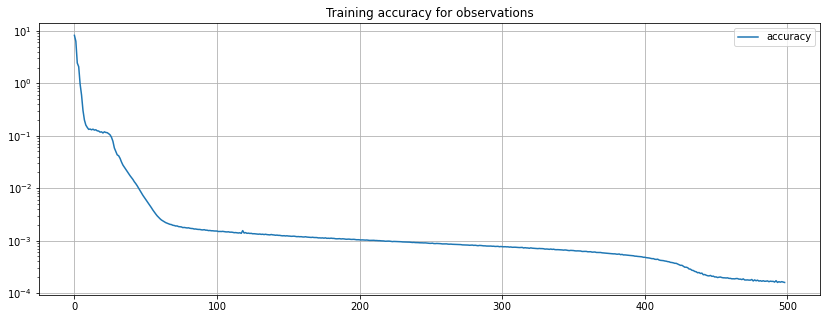

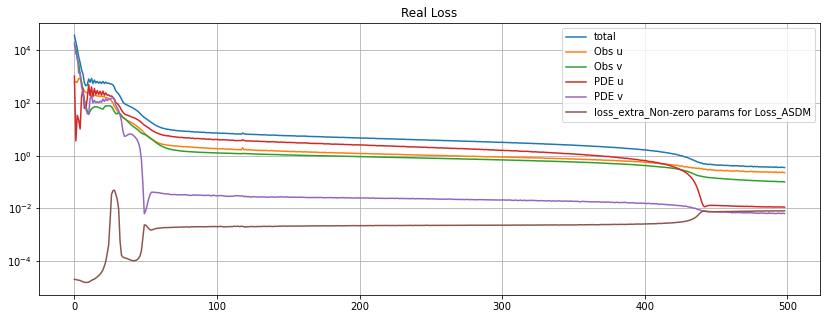

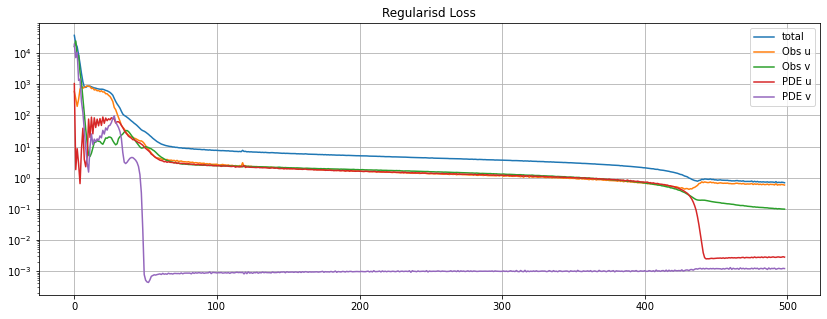

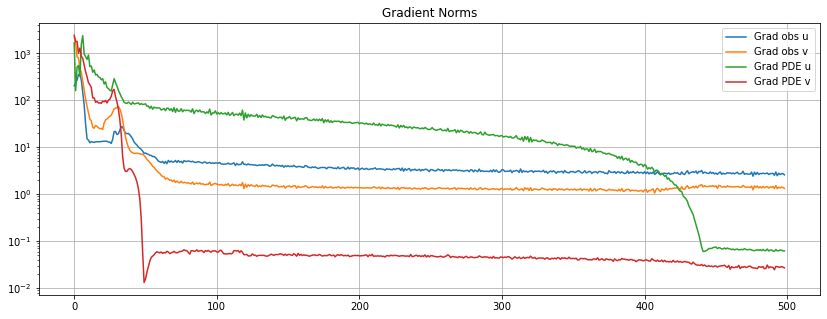

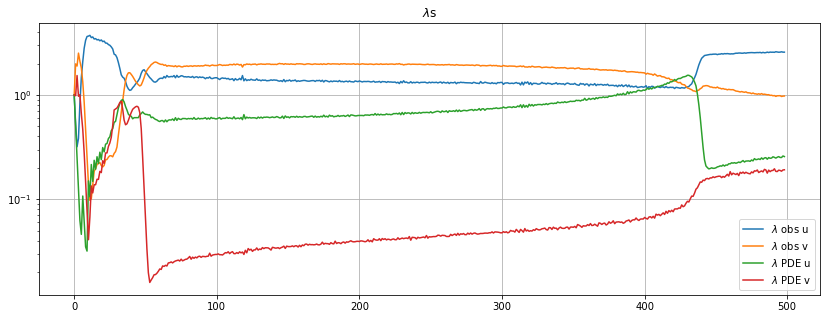

In [20]:
#plot_result(merge_dict(results, results2, results3))
plot_result(merge_dict(results, results2, results3))

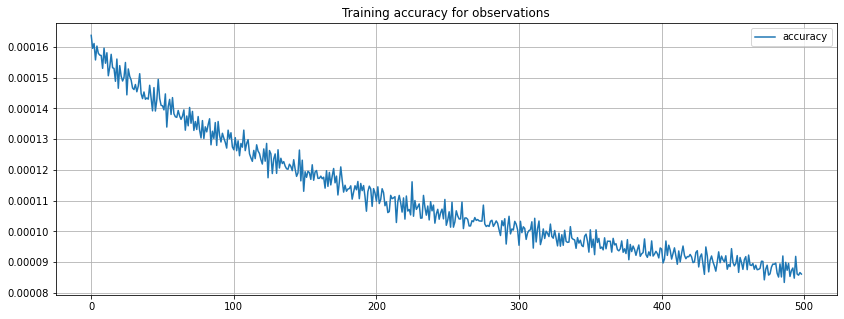

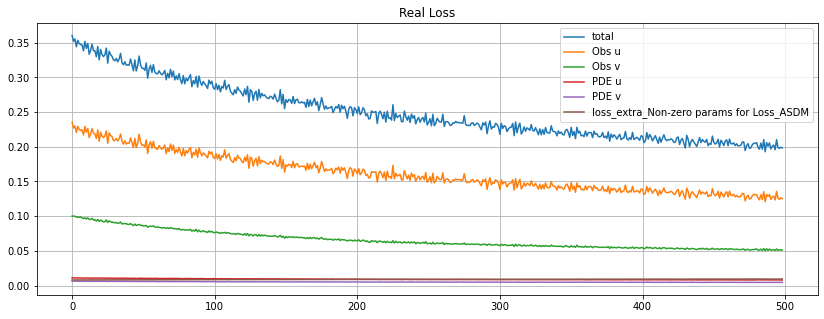

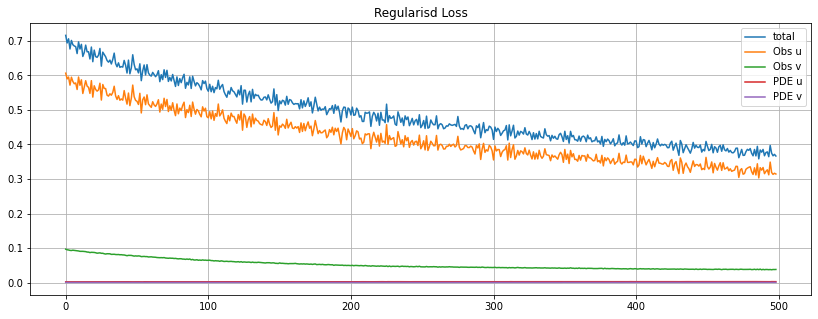

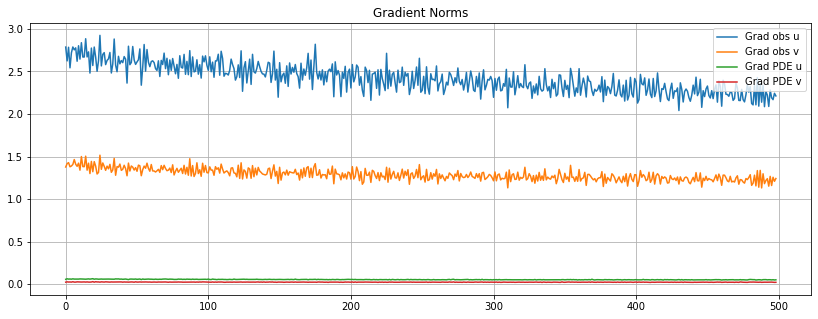

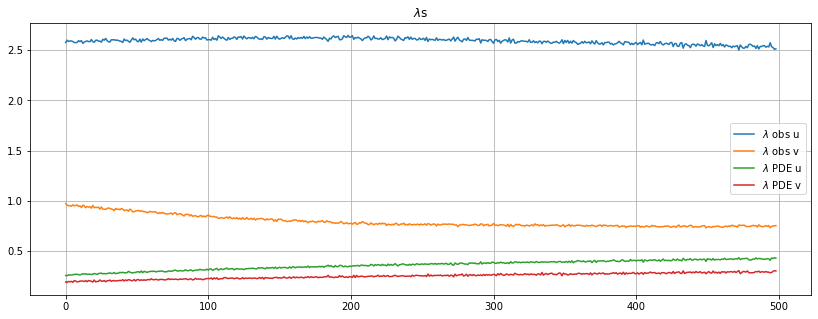

In [23]:
plot_result(results4,yscale='linear')

In [11]:
results = model.train(epochs = 500,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 3.71528149
total loss: 25352.01068011, total regularisd loss: 25352.01068011
obs u loss: 579.76889571, obs v loss: 13613.77178540
pde u loss: 471.44719073, pde v loss: 10687.02280826
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
D_a:0: 9.71731, D_s:0: 12.36267, sigma_a:0: 10.02123, sigma_s:0: 8.43384, mu_a:0: 9.79264, rho_a:0: 10.34118, rho_s:0: 11.85975, kappa_a:0: 8.04046
extra loss: -0.00000000
Time taken: 86.64s

Start of epoch 1
Training observations acc over epoch: 4.10286665
total loss: 11704.80731901, total regularisd loss: 11704.80731901
obs u loss: 587.54160297, obs v loss: 7815.12431373
pde u loss: 0.85487465, pde v loss: 3301.28652765
lambda obs u: 0.55802689, lambda obs v: 2.16515375
lambda pde u: 0.50000044, lambda pde v: 0.77681892
D_a:0: 9.53462, D_s:0: 13.30064, sigma_a:0: 10.06413, sigma_s:0: 7.61515, mu_a:0: 9.69538, rho_a:0: 10.49950, rho_s:0: 12.66910, ka

Training observations acc over epoch: 0.12332802
total loss: 3159.54073240, total regularisd loss: 795.24611331
obs u loss: 202.18911986, obs v loss: 50.38656176
pde u loss: 252.78854739, pde v loss: 110.58108629
lambda obs u: 3.61190369, lambda obs v: 0.09995834
lambda pde u: 0.18299844, lambda pde v: 0.10513953
D_a:0: 7.18809, D_s:0: 12.75139, sigma_a:0: 7.38985, sigma_s:0: 4.24527, mu_a:0: 10.23133, rho_a:0: 9.74464, rho_s:0: 14.69670, kappa_a:0: 3.17640
extra loss: -0.00000000
Time taken: 43.66s

Start of epoch 17
Training observations acc over epoch: 0.12019077
total loss: 3563.93568061, total regularisd loss: 775.68672294
obs u loss: 193.72863832, obs v loss: 52.42208778
pde u loss: 307.61321866, pde v loss: 137.19649498
lambda obs u: 3.51067611, lambda obs v: 0.10303197
lambda pde u: 0.24365534, lambda pde v: 0.14263658
D_a:0: 6.08241, D_s:0: 11.75627, sigma_a:0: 7.12027, sigma_s:0: 4.15685, mu_a:0: 10.04199, rho_a:0: 9.96416, rho_s:0: 14.20637, kappa_a:0: 3.09671
extra loss: -0

Training observations acc over epoch: 0.03942436
total loss: 307.90124007, total regularisd loss: 151.81950126
obs u loss: 24.89673607, obs v loss: 55.84436793
pde u loss: 78.78326232, pde v loss: 28.94866743
lambda obs u: 1.26048779, lambda obs v: 1.28253641
lambda pde u: 0.62348482, lambda pde v: 0.83349099
D_a:0: 0.03177, D_s:0: 0.04401, sigma_a:0: 0.03177, sigma_s:0: 0.36797, mu_a:0: 4.64677, rho_a:0: 14.90568, rho_s:0: 1.20450, kappa_a:0: 2.64421
extra loss: -0.00000000
Time taken: 43.71s

Start of epoch 33
Training observations acc over epoch: 0.03835144
total loss: 167.76929704, total regularisd loss: 145.13170866
obs u loss: 30.13717103, obs v loss: 48.40661978
pde u loss: 58.39967468, pde v loss: 10.37756868
lambda obs u: 1.01483975, lambda obs v: 1.71581581
lambda pde u: 0.69590958, lambda pde v: 0.57343487
D_a:0: 0.03177, D_s:0: 0.02956, sigma_a:0: 0.03177, sigma_s:0: 0.20187, mu_a:0: 4.75255, rho_a:0: 14.36789, rho_s:0: 0.63238, kappa_a:0: 2.50569
extra loss: -0.00000000
Ti

Training observations acc over epoch: 0.00880038
total loss: 79.99869500, total regularisd loss: 39.99955794
obs u loss: 8.93940973, obs v loss: 9.08376426
pde u loss: 16.54310908, pde v loss: 0.11000157
lambda obs u: 1.69769533, lambda obs v: 1.76530923
lambda pde u: 0.53420747, lambda pde v: 0.00278797
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00544, mu_a:0: 6.10879, rho_a:0: 10.37966, rho_s:0: 0.00860, kappa_a:0: 0.91203
extra loss: -0.00000000
Time taken: 44.33s

Start of epoch 49
Training observations acc over epoch: 0.00864510
total loss: 79.45113278, total regularisd loss: 39.12584075
obs u loss: 8.84040541, obs v loss: 8.86475534
pde u loss: 15.85186356, pde v loss: 0.11026019
lambda obs u: 1.67072844, lambda obs v: 1.78903832
lambda pde u: 0.53744622, lambda pde v: 0.00278702
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00524, mu_a:0: 6.08967, rho_a:0: 10.26899, rho_s:0: 0.00861, kappa_a:0: 0.90008
extra loss: -0.00000000
Time taken: 

Training observations acc over epoch: 0.00741376
total loss: 105.29513682, total regularisd loss: 32.72537575
obs u loss: 8.06502481, obs v loss: 7.11836055
pde u loss: 12.19143053, pde v loss: 0.15259672
lambda obs u: 1.57566584, lambda obs v: 1.89636773
lambda pde u: 0.52594566, lambda pde v: 0.00202077
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00701, mu_a:0: 5.50953, rho_a:0: 8.91080, rho_s:0: 0.01114, kappa_a:0: 0.83032
extra loss: -0.00000000
Time taken: 43.48s

Start of epoch 65
Training observations acc over epoch: 0.00726092
total loss: 120.45698766, total regularisd loss: 32.26606275
obs u loss: 7.90418038, obs v loss: 6.96619460
pde u loss: 12.55051741, pde v loss: 0.17763481
lambda obs u: 1.57086336, lambda obs v: 1.87916649
lambda pde u: 0.54778621, lambda pde v: 0.00218394
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00644, mu_a:0: 5.46129, rho_a:0: 8.82325, rho_s:0: 0.00906, kappa_a:0: 0.82869
extra loss: -0.00000000
Time taken: 

Training observations acc over epoch: 0.00662405
total loss: 74.12060693, total regularisd loss: 28.93902146
obs u loss: 7.23976659, obs v loss: 6.32628700
pde u loss: 9.96543297, pde v loss: 0.14359749
lambda obs u: 1.51405879, lambda obs v: 1.88984430
lambda pde u: 0.59350696, lambda pde v: 0.00258996
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00613, mu_a:0: 4.62048, rho_a:0: 7.35909, rho_s:0: 0.00871, kappa_a:0: 0.80820
extra loss: -0.00000000
Time taken: 44.21s

Start of epoch 81
Training observations acc over epoch: 0.00632545
total loss: 141.72918437, total regularisd loss: 28.04923842
obs u loss: 6.77910553, obs v loss: 6.17542579
pde u loss: 10.30130906, pde v loss: 0.30206016
lambda obs u: 1.48452653, lambda obs v: 1.86454679
lambda pde u: 0.64761043, lambda pde v: 0.00331625
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00831, mu_a:0: 4.55666, rho_a:0: 7.24785, rho_s:0: 0.01152, kappa_a:0: 0.80478
extra loss: -0.00000000
Time taken: 43

Training observations acc over epoch: 0.00522387
total loss: 43.75117187, total regularisd loss: 23.27759636
obs u loss: 5.52452519, obs v loss: 5.17396959
pde u loss: 7.84252967, pde v loss: 0.13990553
lambda obs u: 1.31874672, lambda obs v: 1.82090755
lambda pde u: 0.85520777, lambda pde v: 0.00513796
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00658, mu_a:0: 3.23828, rho_a:0: 5.05831, rho_s:0: 0.00941, kappa_a:0: 0.78261
extra loss: -0.00000000
Time taken: 43.93s

Start of epoch 98
Training observations acc over epoch: 0.00522425
total loss: 42.09197684, total regularisd loss: 22.83980768
obs u loss: 5.60644973, obs v loss: 5.09281979
pde u loss: 7.21703471, pde v loss: 0.13669463
lambda obs u: 1.34391553, lambda obs v: 1.80318309
lambda pde u: 0.84770448, lambda pde v: 0.00519690
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00611, mu_a:0: 3.13192, rho_a:0: 4.87571, rho_s:0: 0.00821, kappa_a:0: 0.77733
extra loss: -0.00000000
Time taken: 43.8

Training observations acc over epoch: 0.00083521
total loss: 3.19446024, total regularisd loss: 2.29912258
obs u loss: 1.18636307, obs v loss: 0.52414297
pde u loss: 0.26762830, pde v loss: 0.01802621
lambda obs u: 1.47454166, lambda obs v: 1.14874411
lambda pde u: 1.36171220, lambda pde v: 0.01500204
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00361, mu_a:0: 0.33532, rho_a:0: 0.34206, rho_s:0: 0.00421, kappa_a:0: 0.36266
extra loss: -0.00000000
Time taken: 43.76s

Start of epoch 115
Training observations acc over epoch: 0.00076546
total loss: 2.09208097, total regularisd loss: 2.31883372
obs u loss: 1.12825529, obs v loss: 0.43940016
pde u loss: 0.11031818, pde v loss: 0.01295284
lambda obs u: 1.96145559, lambda obs v: 1.08233348
lambda pde u: 0.93761305, lambda pde v: 0.01859788
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00328, mu_a:0: 0.26050, rho_a:0: 0.24244, rho_s:0: 0.00346, kappa_a:0: 0.30227
extra loss: -0.00000000
Time taken: 43.61s


Training observations acc over epoch: 0.00047538
total loss: 1.13783919, total regularisd loss: 2.13590679
obs u loss: 0.69509834, obs v loss: 0.27847393
pde u loss: 0.06596270, pde v loss: 0.00825020
lambda obs u: 2.68428254, lambda obs v: 0.84180148
lambda pde u: 0.45300008, lambda pde v: 0.02091590
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00336, mu_a:0: 0.20484, rho_a:0: 0.17020, rho_s:0: 0.00294, kappa_a:0: 0.23098
extra loss: -0.00000000
Time taken: 43.92s

Start of epoch 132
Training observations acc over epoch: 0.00048314
total loss: 1.11803657, total regularisd loss: 2.17170654
obs u loss: 0.71035883, obs v loss: 0.27911264
pde u loss: 0.06574060, pde v loss: 0.00787926
lambda obs u: 2.67925501, lambda obs v: 0.83449802
lambda pde u: 0.46435369, lambda pde v: 0.02189328
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00338, mu_a:0: 0.20516, rho_a:0: 0.16960, rho_s:0: 0.00329, kappa_a:0: 0.22985
extra loss: -0.00000000
Time taken: 44.42s


Training observations acc over epoch: 0.00040502
total loss: 0.89643657, total regularisd loss: 1.79864862
obs u loss: 0.60367048, obs v loss: 0.22581913
pde u loss: 0.06235016, pde v loss: 0.00663482
lambda obs u: 2.63822791, lambda obs v: 0.75978839
lambda pde u: 0.57659791, lambda pde v: 0.02538579
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00309, mu_a:0: 0.20057, rho_a:0: 0.16508, rho_s:0: 0.00305, kappa_a:0: 0.22483
extra loss: -0.00000000
Time taken: 43.88s

Start of epoch 149
Training observations acc over epoch: 0.00040531
total loss: 0.88265157, total regularisd loss: 1.80130733
obs u loss: 0.60400436, obs v loss: 0.22607124
pde u loss: 0.06222688, pde v loss: 0.00630183
lambda obs u: 2.63690433, lambda obs v: 0.75392195
lambda pde u: 0.58293489, lambda pde v: 0.02623884
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00290, mu_a:0: 0.20098, rho_a:0: 0.16432, rho_s:0: 0.00299, kappa_a:0: 0.22385
extra loss: -0.00000000
Time taken: 43.67s


Training observations acc over epoch: 0.00035603
total loss: 0.75975243, total regularisd loss: 1.54846719
obs u loss: 0.52833553, obs v loss: 0.20080712
pde u loss: 0.06031395, pde v loss: 0.00539946
lambda obs u: 2.57294708, lambda obs v: 0.73995008
lambda pde u: 0.65895446, lambda pde v: 0.02814838
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00294, mu_a:0: 0.19900, rho_a:0: 0.16266, rho_s:0: 0.00287, kappa_a:0: 0.22042
extra loss: -0.00000000
Time taken: 44.23s

Start of epoch 166
Training observations acc over epoch: 0.00036949
total loss: 0.77557419, total regularisd loss: 1.61181262
obs u loss: 0.55207899, obs v loss: 0.20464465
pde u loss: 0.06034249, pde v loss: 0.00542884
lambda obs u: 2.56093503, lambda obs v: 0.73417483
lambda pde u: 0.67631331, lambda pde v: 0.02857683
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00316, mu_a:0: 0.19909, rho_a:0: 0.16241, rho_s:0: 0.00314, kappa_a:0: 0.22157
extra loss: -0.00000000
Time taken: 44.13s


Training observations acc over epoch: 0.00033368
total loss: 0.70577877, total regularisd loss: 1.42037499
obs u loss: 0.49485828, obs v loss: 0.18851258
pde u loss: 0.05921788, pde v loss: 0.00486222
lambda obs u: 2.49590481, lambda obs v: 0.73062668
lambda pde u: 0.74536093, lambda pde v: 0.02810757
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00307, mu_a:0: 0.19885, rho_a:0: 0.16160, rho_s:0: 0.00287, kappa_a:0: 0.22012
extra loss: -0.00000000
Time taken: 43.59s

Start of epoch 183
Training observations acc over epoch: 0.00032901
total loss: 0.70118589, total regularisd loss: 1.39671555
obs u loss: 0.48728521, obs v loss: 0.18653735
pde u loss: 0.05913046, pde v loss: 0.00481509
lambda obs u: 2.48925309, lambda obs v: 0.73635638
lambda pde u: 0.74555076, lambda pde v: 0.02883977
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00293, mu_a:0: 0.19827, rho_a:0: 0.16144, rho_s:0: 0.00294, kappa_a:0: 0.22024
extra loss: -0.00000000
Time taken: 43.60s


Training observations acc over epoch: 0.00031154
total loss: 0.65980314, total regularisd loss: 1.31608101
obs u loss: 0.46347159, obs v loss: 0.17455326
pde u loss: 0.05855646, pde v loss: 0.00454117
lambda obs u: 2.45270576, lambda obs v: 0.71171247
lambda pde u: 0.80587817, lambda pde v: 0.02970361
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00315, mu_a:0: 0.19845, rho_a:0: 0.16087, rho_s:0: 0.00290, kappa_a:0: 0.21956
extra loss: -0.00000000
Time taken: 43.60s

Start of epoch 200
Training observations acc over epoch: 0.00030758
total loss: 0.65605422, total regularisd loss: 1.28941356
obs u loss: 0.45594773, obs v loss: 0.17398118
pde u loss: 0.05850547, pde v loss: 0.00454779
lambda obs u: 2.43309026, lambda obs v: 0.71271246
lambda pde u: 0.82381419, lambda pde v: 0.03038309
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00295, mu_a:0: 0.19808, rho_a:0: 0.16073, rho_s:0: 0.00306, kappa_a:0: 0.21932
extra loss: -0.00000000
Time taken: 43.45s


Training observations acc over epoch: 0.00028728
total loss: 0.61686410, total regularisd loss: 1.17941653
obs u loss: 0.42374829, obs v loss: 0.16460266
pde u loss: 0.05791945, pde v loss: 0.00445145
lambda obs u: 2.39288311, lambda obs v: 0.70702644
lambda pde u: 0.86812228, lambda pde v: 0.03196817
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00312, mu_a:0: 0.19763, rho_a:0: 0.16028, rho_s:0: 0.00281, kappa_a:0: 0.21813
extra loss: -0.00000000
Time taken: 44.50s

Start of epoch 217
Training observations acc over epoch: 0.00030070
total loss: 0.63094534, total regularisd loss: 1.24105462
obs u loss: 0.44790870, obs v loss: 0.16792910
pde u loss: 0.05804332, pde v loss: 0.00445592
lambda obs u: 2.38841794, lambda obs v: 0.69871669
lambda pde u: 0.88137484, lambda pde v: 0.03149053
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00274, mu_a:0: 0.19750, rho_a:0: 0.16024, rho_s:0: 0.00290, kappa_a:0: 0.21861
extra loss: -0.00000000
Time taken: 44.22s


Training observations acc over epoch: 0.00027981
total loss: 0.60167014, total regularisd loss: 1.12925577
obs u loss: 0.41377303, obs v loss: 0.15928652
pde u loss: 0.05739965, pde v loss: 0.00445432
lambda obs u: 2.32272381, lambda obs v: 0.69524476
lambda pde u: 0.94845281, lambda pde v: 0.03357861
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00306, mu_a:0: 0.19676, rho_a:0: 0.16028, rho_s:0: 0.00275, kappa_a:0: 0.21762
extra loss: -0.00000000
Time taken: 43.96s

Start of epoch 234
Training observations acc over epoch: 0.00027105
total loss: 0.59057352, total regularisd loss: 1.08999186
obs u loss: 0.39908163, obs v loss: 0.15602007
pde u loss: 0.05736964, pde v loss: 0.00449481
lambda obs u: 2.30990904, lambda obs v: 0.70427934
lambda pde u: 0.95260598, lambda pde v: 0.03320564
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00289, mu_a:0: 0.19715, rho_a:0: 0.15981, rho_s:0: 0.00275, kappa_a:0: 0.21818
extra loss: -0.00000000
Time taken: 43.53s


Training observations acc over epoch: 0.00026051
total loss: 0.56851067, total regularisd loss: 1.03478214
obs u loss: 0.38392807, obs v loss: 0.14959101
pde u loss: 0.05603392, pde v loss: 0.00454294
lambda obs u: 2.26736749, lambda obs v: 0.69687393
lambda pde u: 0.99920518, lambda pde v: 0.03655340
D_a:0: 0.03113, D_s:0: 0.03177, sigma_a:0: 0.03176, sigma_s:0: 0.00289, mu_a:0: 0.19629, rho_a:0: 0.15854, rho_s:0: 0.00277, kappa_a:0: 0.21742
extra loss: -0.00000000
Time taken: 44.04s

Start of epoch 251
Training observations acc over epoch: 0.00026581
total loss: 0.57137464, total regularisd loss: 1.05106207
obs u loss: 0.39228351, obs v loss: 0.15208627
pde u loss: 0.05550391, pde v loss: 0.00455357
lambda obs u: 2.30577225, lambda obs v: 0.68208806
lambda pde u: 0.97466361, lambda pde v: 0.03747609
D_a:0: 0.03071, D_s:0: 0.03177, sigma_a:0: 0.03175, sigma_s:0: 0.00343, mu_a:0: 0.19481, rho_a:0: 0.15760, rho_s:0: 0.00271, kappa_a:0: 0.21646
extra loss: -0.00000000
Time taken: 43.84s


Training observations acc over epoch: 0.00025476
total loss: 0.44038924, total regularisd loss: 1.20441351
obs u loss: 0.37779481, obs v loss: 0.14394986
pde u loss: 0.00989034, pde v loss: 0.00438051
lambda obs u: 2.91682185, lambda obs v: 0.85031538
lambda pde u: 0.18554676, lambda pde v: 0.04731600
D_a:0: 0.00199, D_s:0: 0.03176, sigma_a:0: 0.01593, sigma_s:0: 0.00308, mu_a:0: 0.07399, rho_a:0: 0.05533, rho_s:0: 0.00266, kappa_a:0: 0.20176
extra loss: -0.00000000
Time taken: 43.95s

Start of epoch 268
Training observations acc over epoch: 0.00024946
total loss: 0.42195897, total regularisd loss: 1.19597582
obs u loss: 0.36784270, obs v loss: 0.14306108
pde u loss: 0.00640698, pde v loss: 0.00440385
lambda obs u: 2.96161219, lambda obs v: 0.86481299
lambda pde u: 0.12510459, lambda pde v: 0.04847024
D_a:0: 0.00167, D_s:0: 0.03176, sigma_a:0: 0.01253, sigma_s:0: 0.00303, mu_a:0: 0.05884, rho_a:0: 0.04402, rho_s:0: 0.00275, kappa_a:0: 0.20302
extra loss: -0.00000000
Time taken: 44.03s


Training observations acc over epoch: 0.00023551
total loss: 0.68138046, total regularisd loss: 1.19071505
obs u loss: 0.34839435, obs v loss: 0.13393482
pde u loss: 0.00001113, pde v loss: 0.00192126
lambda obs u: 3.07633277, lambda obs v: 0.89965129
lambda pde u: 0.00001887, lambda pde v: 0.02399707
D_a:0: 0.00007, D_s:0: 0.01928, sigma_a:0: 0.00034, sigma_s:0: 0.00204, mu_a:0: 0.00213, rho_a:0: 0.00196, rho_s:0: 0.00200, kappa_a:0: 0.32885
extra loss: -0.00000000
Time taken: 43.75s

Start of epoch 285
Training observations acc over epoch: 0.00023959
total loss: 0.77933540, total regularisd loss: 1.21171717
obs u loss: 0.35386230, obs v loss: 0.13681588
pde u loss: 0.00000860, pde v loss: 0.00135040
lambda obs u: 3.08719385, lambda obs v: 0.89552935
lambda pde u: 0.00001211, lambda pde v: 0.01726469
D_a:0: 0.00008, D_s:0: 0.01569, sigma_a:0: 0.00028, sigma_s:0: 0.00145, mu_a:0: 0.00187, rho_a:0: 0.00174, rho_s:0: 0.00170, kappa_a:0: 0.32947
extra loss: -0.00000000
Time taken: 43.89s


Training observations acc over epoch: 0.00023006
total loss: 2.16390499, total regularisd loss: 1.17154177
obs u loss: 0.34030701, obs v loss: 0.13086445
pde u loss: 0.00000296, pde v loss: 0.00000241
lambda obs u: 3.11294314, lambda obs v: 0.88705148
lambda pde u: 0.00000198, lambda pde v: 0.00000341
D_a:0: 0.00007, D_s:0: 0.00066, sigma_a:0: 0.00009, sigma_s:0: 0.00007, mu_a:0: 0.00083, rho_a:0: 0.00080, rho_s:0: 0.00007, kappa_a:0: 0.32980
extra loss: -0.00000000
Time taken: 43.66s

Start of epoch 302
Training observations acc over epoch: 0.00022444
total loss: 2.28960744, total regularisd loss: 1.14374130
obs u loss: 0.33065534, obs v loss: 0.12900043
pde u loss: 0.00000289, pde v loss: 0.00000196
lambda obs u: 3.11749288, lambda obs v: 0.88250289
lambda pde u: 0.00000195, lambda pde v: 0.00000229
D_a:0: 0.00006, D_s:0: 0.00059, sigma_a:0: 0.00009, sigma_s:0: 0.00006, mu_a:0: 0.00080, rho_a:0: 0.00078, rho_s:0: 0.00007, kappa_a:0: 0.32980
extra loss: -0.00000000
Time taken: 44.28s


Training observations acc over epoch: 0.00024923
total loss: 1.67167190, total regularisd loss: 1.11303305
obs u loss: 0.36051100, obs v loss: 0.14991093
pde u loss: 0.32756211, pde v loss: 0.14871098
lambda obs u: 0.59731648, lambda obs v: 0.19670735
lambda pde u: 2.22044217, lambda pde v: 0.98553400
D_a:0: 0.03177, D_s:0: 0.17925, sigma_a:0: 0.03177, sigma_s:0: 0.02987, mu_a:0: 0.03177, rho_a:0: 0.00704, rho_s:0: 0.01827, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.23s

Start of epoch 318
Training observations acc over epoch: 0.00024655
total loss: 1.63767866, total regularisd loss: 1.10499848
obs u loss: 0.35726062, obs v loss: 0.14767856
pde u loss: 0.32643007, pde v loss: 0.13975396
lambda obs u: 0.59790398, lambda obs v: 0.19869536
lambda pde u: 2.26334493, lambda pde v: 0.94005574
D_a:0: 0.03177, D_s:0: 0.17255, sigma_a:0: 0.03177, sigma_s:0: 0.02873, mu_a:0: 0.03177, rho_a:0: 0.00725, rho_s:0: 0.01755, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.25s


Training observations acc over epoch: 0.00023339
total loss: 1.38516609, total regularisd loss: 1.23707567
obs u loss: 0.34905015, obs v loss: 0.12892953
pde u loss: 0.31158883, pde v loss: 0.00019543
lambda obs u: 0.81696362, lambda obs v: 0.21715400
lambda pde u: 2.96547215, lambda pde v: 0.00041023
D_a:0: 0.03177, D_s:0: 0.00443, sigma_a:0: 0.03177, sigma_s:0: 0.00090, mu_a:0: 0.03177, rho_a:0: 0.00741, rho_s:0: 0.00053, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.31s

Start of epoch 335
Training observations acc over epoch: 0.00023584
total loss: 1.50329086, total regularisd loss: 1.23768782
obs u loss: 0.35272348, obs v loss: 0.13028272
pde u loss: 0.31065343, pde v loss: 0.00015048
lambda obs u: 0.79940252, lambda obs v: 0.21478014
lambda pde u: 2.98559227, lambda pde v: 0.00022508
D_a:0: 0.03177, D_s:0: 0.00380, sigma_a:0: 0.03177, sigma_s:0: 0.00079, mu_a:0: 0.03177, rho_a:0: 0.00718, rho_s:0: 0.00047, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.21s


Training observations acc over epoch: 0.00023048
total loss: 7.41363855, total regularisd loss: 1.18788048
obs u loss: 0.34181775, obs v loss: 0.13019654
pde u loss: 0.29732495, pde v loss: 0.00000372
lambda obs u: 0.81003035, lambda obs v: 0.22403945
lambda pde u: 2.96592963, lambda pde v: 0.00000057
D_a:0: 0.03177, D_s:0: 0.00092, sigma_a:0: 0.03177, sigma_s:0: 0.00007, mu_a:0: 0.03177, rho_a:0: 0.00748, rho_s:0: 0.00005, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 43.95s

Start of epoch 352
Training observations acc over epoch: 0.00023032
total loss: 7.07917696, total regularisd loss: 1.18585022
obs u loss: 0.34227302, obs v loss: 0.12942200
pde u loss: 0.29656909, pde v loss: 0.00000340
lambda obs u: 0.81337975, lambda obs v: 0.22511280
lambda pde u: 2.96150691, lambda pde v: 0.00000054
D_a:0: 0.03177, D_s:0: 0.00088, sigma_a:0: 0.03177, sigma_s:0: 0.00006, mu_a:0: 0.03177, rho_a:0: 0.00765, rho_s:0: 0.00005, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.02s


Training observations acc over epoch: 0.00027591
total loss: 1.80187997, total regularisd loss: 1.19019001
obs u loss: 0.36592382, obs v loss: 0.19913706
pde u loss: 0.29539253, pde v loss: 0.29406470
lambda obs u: 0.52812565, lambda obs v: 0.26741951
lambda pde u: 1.61690686, lambda pde v: 1.58754799
D_a:0: 0.03177, D_s:0: 0.33882, sigma_a:0: 0.03177, sigma_s:0: 0.04282, mu_a:0: 0.03177, rho_a:0: 0.00753, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.30s

Start of epoch 368
Training observations acc over epoch: 0.00027395
total loss: 1.79821786, total regularisd loss: 1.18619184
obs u loss: 0.36119593, obs v loss: 0.19985572
pde u loss: 0.29503692, pde v loss: 0.29286829
lambda obs u: 0.51625997, lambda obs v: 0.26550939
lambda pde u: 1.62572020, lambda pde v: 1.59251044
D_a:0: 0.03177, D_s:0: 0.34113, sigma_a:0: 0.03177, sigma_s:0: 0.04326, mu_a:0: 0.03177, rho_a:0: 0.00733, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.16s


Training observations acc over epoch: 0.00027325
total loss: 1.81372052, total regularisd loss: 1.15611799
obs u loss: 0.36392376, obs v loss: 0.19569681
pde u loss: 0.28862710, pde v loss: 0.28086198
lambda obs u: 0.51312631, lambda obs v: 0.26455268
lambda pde u: 1.64466312, lambda pde v: 1.57765789
D_a:0: 0.03177, D_s:0: 0.34445, sigma_a:0: 0.03177, sigma_s:0: 0.04401, mu_a:0: 0.03177, rho_a:0: 0.00743, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.17s

Start of epoch 385
Training observations acc over epoch: 0.00026268
total loss: 1.75399989, total regularisd loss: 1.14510632
obs u loss: 0.34552581, obs v loss: 0.19245090
pde u loss: 0.28836687, pde v loss: 0.28056031
lambda obs u: 0.52303278, lambda obs v: 0.26755344
lambda pde u: 1.63720319, lambda pde v: 1.57221059
D_a:0: 0.03177, D_s:0: 0.34631, sigma_a:0: 0.03177, sigma_s:0: 0.04324, mu_a:0: 0.03177, rho_a:0: 0.00694, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 43.84s


Training observations acc over epoch: 0.00026129
total loss: 1.73942542, total regularisd loss: 1.12500873
obs u loss: 0.34636374, obs v loss: 0.18875420
pde u loss: 0.28315691, pde v loss: 0.27396998
lambda obs u: 0.50816064, lambda obs v: 0.26228904
lambda pde u: 1.65157453, lambda pde v: 1.57797579
D_a:0: 0.03177, D_s:0: 0.34906, sigma_a:0: 0.03177, sigma_s:0: 0.04355, mu_a:0: 0.03177, rho_a:0: 0.00704, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.02s

Start of epoch 402
Training observations acc over epoch: 0.00026786
total loss: 1.77558783, total regularisd loss: 1.13085234
obs u loss: 0.35808146, obs v loss: 0.19049225
pde u loss: 0.28297919, pde v loss: 0.27349227
lambda obs u: 0.50697167, lambda obs v: 0.26203519
lambda pde u: 1.65286800, lambda pde v: 1.57812514
D_a:0: 0.03177, D_s:0: 0.34850, sigma_a:0: 0.03177, sigma_s:0: 0.04290, mu_a:0: 0.03177, rho_a:0: 0.00740, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 43.76s


Training observations acc over epoch: 0.00026163
total loss: 1.76006800, total regularisd loss: 1.11011797
obs u loss: 0.34884071, obs v loss: 0.18698536
pde u loss: 0.27881945, pde v loss: 0.26856984
lambda obs u: 0.50291044, lambda obs v: 0.26263068
lambda pde u: 1.65712529, lambda pde v: 1.57733359
D_a:0: 0.03177, D_s:0: 0.34916, sigma_a:0: 0.03177, sigma_s:0: 0.04245, mu_a:0: 0.03177, rho_a:0: 0.00727, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.03s

Start of epoch 419
Training observations acc over epoch: 0.00025704
total loss: 1.72455541, total regularisd loss: 1.10499474
obs u loss: 0.33978275, obs v loss: 0.18662756
pde u loss: 0.27854267, pde v loss: 0.26850390
lambda obs u: 0.49819620, lambda obs v: 0.25977601
lambda pde u: 1.66152572, lambda pde v: 1.58050207
D_a:0: 0.03177, D_s:0: 0.35315, sigma_a:0: 0.03177, sigma_s:0: 0.04329, mu_a:0: 0.03177, rho_a:0: 0.00698, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.12s


Training observations acc over epoch: 0.00026119
total loss: 1.72449808, total regularisd loss: 1.09935606
obs u loss: 0.35046703, obs v loss: 0.18445191
pde u loss: 0.27506576, pde v loss: 0.26528343
lambda obs u: 0.49725701, lambda obs v: 0.25750977
lambda pde u: 1.66304918, lambda pde v: 1.58218405
D_a:0: 0.03177, D_s:0: 0.35470, sigma_a:0: 0.03177, sigma_s:0: 0.04332, mu_a:0: 0.03177, rho_a:0: 0.00734, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.44s

Start of epoch 436
Training observations acc over epoch: 0.00025390
total loss: 1.72155930, total regularisd loss: 1.08989625
obs u loss: 0.33653563, obs v loss: 0.18345797
pde u loss: 0.27471959, pde v loss: 0.26446806
lambda obs u: 0.50324562, lambda obs v: 0.26214464
lambda pde u: 1.65785515, lambda pde v: 1.57675458
D_a:0: 0.03177, D_s:0: 0.35816, sigma_a:0: 0.03177, sigma_s:0: 0.04300, mu_a:0: 0.03177, rho_a:0: 0.00712, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 43.90s


Training observations acc over epoch: 0.00025027
total loss: 1.68630579, total regularisd loss: 1.07657388
obs u loss: 0.33242052, obs v loss: 0.18012710
pde u loss: 0.27162640, pde v loss: 0.26152805
lambda obs u: 0.48830334, lambda obs v: 0.26081324
lambda pde u: 1.66574251, lambda pde v: 1.58514091
D_a:0: 0.03177, D_s:0: 0.35745, sigma_a:0: 0.03177, sigma_s:0: 0.04340, mu_a:0: 0.03177, rho_a:0: 0.00764, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.54s

Start of epoch 453
Training observations acc over epoch: 0.00025022
total loss: 1.70064041, total regularisd loss: 1.07498608
obs u loss: 0.33130597, obs v loss: 0.18113689
pde u loss: 0.27140210, pde v loss: 0.26109941
lambda obs u: 0.49143029, lambda obs v: 0.25932608
lambda pde u: 1.66554314, lambda pde v: 1.58370049
D_a:0: 0.03177, D_s:0: 0.35721, sigma_a:0: 0.03177, sigma_s:0: 0.04230, mu_a:0: 0.03177, rho_a:0: 0.00778, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.43s


Training observations acc over epoch: 0.00025264
total loss: 1.69779980, total regularisd loss: 1.07030009
obs u loss: 0.33687335, obs v loss: 0.18053252
pde u loss: 0.26915526, pde v loss: 0.25856048
lambda obs u: 0.49447701, lambda obs v: 0.25578107
lambda pde u: 1.66968010, lambda pde v: 1.58006182
D_a:0: 0.03177, D_s:0: 0.35702, sigma_a:0: 0.03177, sigma_s:0: 0.04299, mu_a:0: 0.03177, rho_a:0: 0.00748, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.23s

Start of epoch 470
Training observations acc over epoch: 0.00024971
total loss: 1.69994589, total regularisd loss: 1.06733163
obs u loss: 0.33072243, obs v loss: 0.18068828
pde u loss: 0.26915246, pde v loss: 0.25833283
lambda obs u: 0.49147213, lambda obs v: 0.25772456
lambda pde u: 1.67010716, lambda pde v: 1.58069615
D_a:0: 0.03177, D_s:0: 0.35425, sigma_a:0: 0.03177, sigma_s:0: 0.04283, mu_a:0: 0.03177, rho_a:0: 0.00753, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.05s


Training observations acc over epoch: 0.00024334
total loss: 1.66041530, total regularisd loss: 1.05384919
obs u loss: 0.32144009, obs v loss: 0.17692117
pde u loss: 0.26722203, pde v loss: 0.25602383
lambda obs u: 0.48434573, lambda obs v: 0.25998138
lambda pde u: 1.67238661, lambda pde v: 1.58328628
D_a:0: 0.03177, D_s:0: 0.36006, sigma_a:0: 0.03177, sigma_s:0: 0.04335, mu_a:0: 0.03177, rho_a:0: 0.00796, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.45s

Start of epoch 487
Training observations acc over epoch: 0.00024363
total loss: 1.66692022, total regularisd loss: 1.05349286
obs u loss: 0.32184708, obs v loss: 0.17709833
pde u loss: 0.26704013, pde v loss: 0.25577876
lambda obs u: 0.47687979, lambda obs v: 0.25933405
lambda pde u: 1.67745487, lambda pde v: 1.58633129
D_a:0: 0.03177, D_s:0: 0.35782, sigma_a:0: 0.03177, sigma_s:0: 0.04338, mu_a:0: 0.03177, rho_a:0: 0.00744, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.11s


In [ ]:
(4e-6/epsilon)*(tf.pow(1e-6/(params+1e-10), twelve) - tf.pow(1e-6/(params+1e-10), six))

In [9]:
def LJ(x):
    return (4e-6/2)*((1e-6/(x+1e-10))**12 - (1e-6/(x+1e-10))**6)

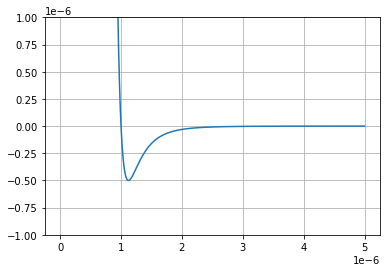

In [10]:
x = np.linspace(0,5e-6, 20000)
plt.plot(x, LJ(x))
#plt.yscale('log')
plt.ylim([-.000001, .000001])
plt.grid()
plt.show()

In [41]:
LJ(.09*1e-6)

1746917.0365552774

In [11]:
LJ(0.000000003177)

1.3041054175600286e+24

In [56]:
LJ(1e-7)

1976153.2866794027

In [40]:
def f(x):
    return 1/(x+0.001)

def f2(x):
    return 1/(x)

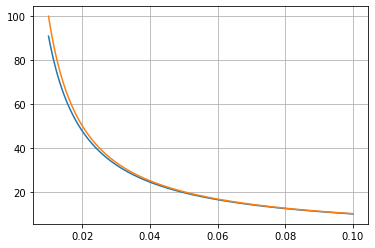

In [44]:
x = np.linspace(0.01,.1, 2000)
plt.plot(x, f(x))
plt.plot(x, f2(x))
#plt.ylim([1,3])
plt.grid()